# Transcriptome visualization

Jupyter notebook containing code for visualizing cell type annotations and other transcriptomic features. 

Input files required include:
1. Filtered cell type assignment matrices for query datasets from ##_centroid_mapping.ipynb
2. Query embeddings from ##_centroid_mapping.ipynb
3. Metadata file for the reference atlas used to call cell types, which at a minimum, should contain cell type annotation columns and UMAP coordinates
4. Sparse matrices for each query and reference dataset
5. Rabies barcode matrices to check rabies infection status
6. Helper index matrices to check helper infection status
7. sample_corr_scores.csv files for adding maximum centroid score for scaling points on plots

Output files include: 

Module and their versions used when generating figures for the paper can be found in 'requirements.txt', which is stored in our GitHub repository: https://github.com/MEUrbanek/rabies_barcode_tech

This code was last amended by Maddie Urbanek on 12/12/2025

## Notebook set-up

In [18]:
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ast
from scipy import stats
import os
import math
from scipy.stats import binomtest
from scipy.stats import entropy
from scipy.stats import binom

pd.options.mode.chained_assignment = None
import scanpy as sc
import anndata as ad

In [19]:
import os
os.chdir('/Users/maddieurbanek/Desktop/revision_data/resubmission/data/transcriptome/')

## Import data

Filtered query sparse matrices from ##_transcriptome_qc_doublet_filtering should be read in for making an AnnData file

In [20]:
#Query datasets
s1_matrix=pd.read_table('./filtered_sparse_matrices/s1_sparse.csv',delimiter=',',index_col=0)
s2_matrix=pd.read_table('./filtered_sparse_matrices/s2_sparse.csv',delimiter=',',index_col=0)
s3_matrix=pd.read_table('./filtered_sparse_matrices/s3_sparse.csv',delimiter=',',index_col=0)
s4_matrix=pd.read_table('./filtered_sparse_matrices/s4_sparse.csv',delimiter=',',index_col=0)
s5_matrix=pd.read_table('./filtered_sparse_matrices/s5_sparse.csv',delimiter=',',index_col=0)

c1_matrix=pd.read_table('./filtered_sparse_matrices/c1_sparse.csv',delimiter=',',index_col=0)
c2_matrix=pd.read_table('./filtered_sparse_matrices/c2_sparse.csv',delimiter=',',index_col=0)
c3_matrix=pd.read_table('./filtered_sparse_matrices/c3_sparse.csv',delimiter=',',index_col=0)
c4_matrix=pd.read_table('./filtered_sparse_matrices/c4_sparse.csv',delimiter=',',index_col=0)

n1_matrix=pd.read_table('./filtered_sparse_matrices/n1_sparse.csv',delimiter=',',index_col=0)
n2_matrix=pd.read_table('./filtered_sparse_matrices/n2_sparse.csv',delimiter=',',index_col=0)
n3_matrix=pd.read_table('./filtered_sparse_matrices/n3_sparse.csv',delimiter=',',index_col=0)
n4_matrix=pd.read_table('./filtered_sparse_matrices/n4_sparse.csv',delimiter=',',index_col=0)

u1_matrix=pd.read_table('./filtered_sparse_matrices/u1_sparse.csv',delimiter=',',index_col=0)
u2_matrix=pd.read_table('./filtered_sparse_matrices/u2_sparse.csv',delimiter=',',index_col=0)

In [21]:
#Reference dataset
ref = pd.read_table('./ref_matrix.csv',delimiter=',',index_col=0)

In [22]:
#Set reference dataset back to raw counts
raw_ref_data = np.expm1(ref)
raw_ref_data

ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1  \
AL627309.1                                  0.0   
AL627309.5                                  0.0   
AL669831.2                                  0.0   
LINC01409                                   2.0   
FAM87B                                      0.0   
...                                         ...   
AP001591.1                                  0.0   
LINC01148                                   0.0   
CYP2A13                                     0.0   
AL121823.1                                  0.0   
TCP11X1                                     0.0   

            ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1  \
AL627309.1                                  0.0   
AL627309.5                                  0.0   
AL669831.2                                  0.0   
LINC01409                                   0.0   
FAM87B                                      0.0   
...                                         ...   
AP001591.1                                  0.0   
LINC01148                                   0.0   
CYP2A13                                     0.0   
AL121823.1                                  0.0   
TCP11X1                                     0.0   

            ARKFrozen.18.PFC_AAACAGCCACTAAATC.1  \
AL627309.1                                  0.0   
AL627309.5                                  0.0   
AL669831.2                                  0.0   
LINC01409                                   0.0   
FAM87B                                      0.0   
...                                         ...   
AP001591.1                                  0.0   
LINC01148                                   0.0   
CYP2A13                                     0.0   
AL121823.1                                  0.0   
TCP11X1                                     0.0   

            ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1  \
AL627309.1                                  0.0   
AL627309.5                                  0.0   
AL669831.2                                  0.0   
LINC01409                                   0.0   
FAM87B                                      0.0   
...                                         ...   
AP001591.1                                  0.0   
LINC01148                                   0.0   
CYP2A13                                     0.0   
AL121823.1                                  0.0   
TCP11X1                                     0.0   

            ARKFrozen.18.PFC_AAACAGCCATCCATCT.1  \
AL627309.1                                  0.0   
AL627309.5                                  0.0   
AL669831.2                                  0.0   
LINC01409                                   0.0   
FAM87B                                      0.0   
...                                         ...   
AP001591.1                                  0.0   
LINC01148                                   0.0   
CYP2A13                                     0.0   
AL121823.1                                  0.0   
TCP11X1                                     0.0   

            ARKFrozen.18.PFC_AAACAGCCATGAATAG.1  \
AL627309.1                                  0.0   
AL627309.5                                  0.0   
AL669831.2                                  0.0   
LINC01409                                   0.0   
FAM87B                                      0.0   
...                                         ...   
AP001591.1                                  0.0   
LINC01148                                   0.0   
CYP2A13                                     0.0   
AL121823.1                                  0.0   
TCP11X1                                     0.0   

            ARKFrozen.18.PFC_AAACAGCCATTAGGTT.1  \
AL627309.1                                  0.0   
AL627309.5                                  0.0   
AL669831.2                                  0.0   
LINC01409                                   0.0   
FAM87B                                      0.0   
...                         

Rabies barcode count matrices and helper count matrices that have been calculated for each dataset need to be read in to identify what cells are rabies+ vs. helper+

In [23]:
#Rabies
s1=pd.read_table('../barcode_count_matrices/s1_completecounts.tsv',delimiter='\t')
s1['datasetid']='s1'
s1['CBC'] = s1['CBC'].str.replace("'", "")
s1['CBC'] = s1['CBC'].str.replace('b', 's1_')
s1['barcode'] = 's1_' + s1['barcode']

s2=pd.read_table('../barcode_count_matrices/s2_completecounts.tsv',delimiter='\t')
s2['datasetid']='s2'
s2['CBC'] = s2['CBC'].str.replace("'", "")
s2['CBC'] = s2['CBC'].str.replace('b', 's2_')
s2['barcode'] = 's2' + s2['barcode']

s3=pd.read_table('../barcode_count_matrices/s3_completecounts.tsv',delimiter='\t')
s3['datasetid']='s3'
s3['CBC'] = s3['CBC'].str.replace("'", "")
s3['CBC'] = s3['CBC'].str.replace('b', 's3_')
s3['barcode'] = 's3_' + s3['barcode']

s4=pd.read_table('../barcode_count_matrices/s4_completecounts.tsv',delimiter='\t')
s4['datasetid']='s4'
s4['CBC'] = s4['CBC'].str.replace("'", "")
s4['CBC'] = s4['CBC'].str.replace('b', 's4_')
s4['barcode'] = 's4_' + s4['barcode']

s5=pd.read_table('../barcode_count_matrices/s5_completecounts.tsv',delimiter='\t')
s5['datasetid']='s5'
s5['CBC'] = s5['CBC'].str.replace("'", "")
s5['CBC'] = s5['CBC'].str.replace('b', 's5_')
s5['barcode'] = 's5_' + s5['barcode']

c1=pd.read_table('../barcode_count_matrices/c1_completecounts.tsv',delimiter='\t')
c1['datasetid']='c1'
c1['CBC'] = c1['CBC'].str.replace("'", "")
c1['CBC'] = c1['CBC'].str.replace('b', 'c1_')
c1['barcode'] = 'c1_' + c1['barcode']

c2=pd.read_table('../barcode_count_matrices/c2_completecounts.tsv',delimiter='\t')
c2['datasetid']='c2'
c2['CBC'] = c2['CBC'].str.replace("'", "")
c2['CBC'] = c2['CBC'].str.replace('b', 'c2_')
c2['barcode'] = 'c2_' + c2['barcode']

n1=pd.read_table('../barcode_count_matrices/n1_completecounts.tsv',delimiter='\t')
n1['datasetid']='n1'
n1['CBC'] = n1['CBC'].str.replace("'", "")
n1['CBC'] = n1['CBC'].str.replace('b', 'n1_')
n1['barcode'] = 'n1_' + n1['barcode']

n2=pd.read_table('../barcode_count_matrices/n2_completecounts.tsv',delimiter='\t')
n2['datasetid']='n2'
n2['CBC'] = n2['CBC'].str.replace("'", "")
n2['CBC'] = n2['CBC'].str.replace('b', 'n2_')
n2['barcode'] = 'n2_' + n2['barcode']

c3=pd.read_table('../barcode_count_matrices/c3_completecounts.tsv',delimiter='\t')
c3['datasetid']='c3'
c3['CBC'] = c3['CBC'].str.replace("'", "")
c3['CBC'] = c3['CBC'].str.replace('b', 'c3_')
c3['barcode'] = 'c3_' + c3['barcode']

c4=pd.read_table('../barcode_count_matrices/c4_completecounts.tsv',delimiter='\t')
c4['datasetid']='c4'
c4['CBC'] = c4['CBC'].str.replace("'", "")
c4['CBC'] = c4['CBC'].str.replace('b', 'c4_')
c4['barcode'] = 'c4_' + c4['barcode']

n3=pd.read_table('../barcode_count_matrices/n3_completecounts.tsv',delimiter='\t')
n3['datasetid']='n3'
n3['CBC'] = n3['CBC'].str.replace("'", "")
n3['CBC'] = n3['CBC'].str.replace('b', 'n3_')
n3['barcode'] = 'n3_' + n3['barcode']

n4=pd.read_table('../barcode_count_matrices/n4_completecounts.tsv',delimiter='\t')
n4['datasetid']='n4'
n4['CBC'] = n4['CBC'].str.replace("'", "")
n4['CBC'] = n4['CBC'].str.replace('b', 'n4_')
n4['barcode'] = 'n4_' + n4['barcode']

#Final barcode matrices across all experiments are concatenated into one large dataframe
barcodes_df=pd.concat([s1,s2,s3,s4,s5,c1,c2,c3,c4,n1,n2,n3,n4], ignore_index=True, axis=0)
barcodes_df

CBC  \
0         s1_CACACAGGACTAATAC   
1         s1_ATTGACCTCCTAAGCA   
2         s1_CATACCAACATTACAT   
3         s1_ATTGAGCCCAGCATCA   
4         s1_AACCCATCACAGCAGA   
...                       ...   
44655647  n4_CCACCCTTCCGAAAAA   
44655648  n4_CCTCAATGACCACAGC   
44655649  n4_AAGGAGGGAGCAACGC   
44655650  n4_AGAGCAATCACGACGC   
44655651  n4_CACGCAGGCCACACTC   

                                                    barcode  UMI_Count  \
0         s1_AATTCAAACCCCTGGCGATGG-GATCCATTTCCCAACGGCTG-...          1   
1         s1_AATTCAAACCCCTGGCGATGG-GATCCATTTCCCAACGGCTG-...          1   
2         s1_AATTCAAACCCCTGGCGATGG-GATCCATTTCCCAACGGCTG-...          1   
3         s1_AATTCAAACCCCTGGCGATGG-GATCCATTTCCCAACGGCTG-...          1   
4         s1_AATTCAAACCCCTGGCGATGG-GATCCATTTCCCAACGGCTG-...          1   
...                                                     ...        ...   
44655647  n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...          1   
44655648  n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...          1   
44655649  n4_AATTCTTTTGGTGCGAGCCTG-GATCTGTCATCGCAGCTCTG-...          1   
44655650  n4_AATTCTTTTGGTGCGAGCCTG-GATCTTTGCGCGAGTCACTG-...          1   
44655651  n4_AATTCTTTTGGTGCGAGCCTG-GATCTTTGCGCGAGTCACTG-...          1   

         datasetid  
0               s1  
1               s1  
2               s1  
3               s1  
4               s1  
...            ...  
44655647        n4  
44655648        n4  
44655649        n4  
44655650        n4  
44655651        n4  

[44655652 rows x 4 columns]

In [24]:
#Helper
s1_helper=pd.read_table('../barcode_count_matrices/s1_helperindex.tsv',delimiter='\t')
s1_helper['datasetid']='s1'
s1_helper['CBC'] = s1_helper['CBC'].str.replace("'", "")
s1_helper['CBC'] = s1_helper['CBC'].str.replace('b', 's1_')

s2_helper=pd.read_table('../barcode_count_matrices/s2_helperindex.tsv',delimiter='\t')
s2_helper['datasetid']='s2'
s2_helper['CBC'] = s2_helper['CBC'].str.replace("'", "")
s2_helper['CBC'] = s2_helper['CBC'].str.replace('b', 's2_')

s3_helper=pd.read_table('../barcode_count_matrices/s3_helperindex.tsv',delimiter='\t')
s3_helper['datasetid']='s3'
s3_helper['CBC'] = s3_helper['CBC'].str.replace("'", "")
s3_helper['CBC'] = s3_helper['CBC'].str.replace('b', 's3_')

s4_helper=pd.read_table('../barcode_count_matrices/s4_helperindex.tsv',delimiter='\t')
s4_helper['datasetid']='s4'
s4_helper['CBC'] = s4_helper['CBC'].str.replace("'", "")
s4_helper['CBC'] = s4_helper['CBC'].str.replace('b', 's4_')

s5_helper=pd.read_table('../barcode_count_matrices/s5_helperindex.tsv',delimiter='\t')
s5_helper['datasetid']='s5'
s5_helper['CBC'] = s5_helper['CBC'].str.replace("'", "")
s5_helper['CBC'] = s5_helper['CBC'].str.replace('b', 's5_')

c1_helper=pd.read_table('../barcode_count_matrices/c1_helperindex.tsv',delimiter='\t')
c1_helper['datasetid']='c1'
c1_helper['CBC'] = c1_helper['CBC'].str.replace("'", "")
c1_helper['CBC'] = c1_helper['CBC'].str.replace('b', 'c1_')

c2_helper=pd.read_table('../barcode_count_matrices/c2_helperindex.tsv',delimiter='\t')
c2_helper['datasetid']='c2'
c2_helper['CBC'] = c2_helper['CBC'].str.replace("'", "")
c2_helper['CBC'] = c2_helper['CBC'].str.replace('b', 'c2_')

c3_helper=pd.read_table('../barcode_count_matrices/c3_helperindex.tsv',delimiter='\t')
c3_helper['datasetid']='c3'
c3_helper['CBC'] = c3_helper['CBC'].str.replace("'", "")
c3_helper['CBC'] = c3_helper['CBC'].str.replace('b', 'c3_')

c4_helper=pd.read_table('../barcode_count_matrices/c4_helperindex.tsv',delimiter='\t')
c4_helper['datasetid']='c4'
c4_helper['CBC'] = c4_helper['CBC'].str.replace("'", "")
c4_helper['CBC'] = c4_helper['CBC'].str.replace('b', 'c4_')

n1_helper=pd.read_table('../barcode_count_matrices/n1_helperindex.tsv',delimiter='\t')
n1_helper['datasetid']='n1'
n1_helper['CBC'] = n1_helper['CBC'].str.replace("'", "")
n1_helper['CBC'] = n1_helper['CBC'].str.replace('b', 'n1_')

n2_helper=pd.read_table('../barcode_count_matrices/n2_helperindex.tsv',delimiter='\t')
n2_helper['datasetid']='n2'
n2_helper['CBC'] = n2_helper['CBC'].str.replace("'", "")
n2_helper['CBC'] = n2_helper['CBC'].str.replace('b', 'n2_')

n3_helper=pd.read_table('../barcode_count_matrices/n3_helperindex.tsv',delimiter='\t')
n3_helper['datasetid']='n3'
n3_helper['CBC'] = n3_helper['CBC'].str.replace("'", "")
n3_helper['CBC'] = n3_helper['CBC'].str.replace('b', 'n3_')

n4_helper=pd.read_table('../barcode_count_matrices/n4_helperindex.tsv',delimiter='\t')
n4_helper['datasetid']='n4'
n4_helper['CBC'] = n4_helper['CBC'].str.replace("'", "")
n4_helper['CBC'] = n4_helper['CBC'].str.replace('b', 'n4_')

helpers_df=pd.concat([s1_helper,s2_helper,s3_helper,s4_helper,s5_helper,c1_helper,c2_helper,c3_helper,c4_helper, n1_helper,n2_helper,n3_helper,n4_helper], ignore_index=True, axis=0)
helpers_df=helpers_df[['CBC','UMI_Count','datasetid']]
helpers_df

CBC  UMI_Count datasetid
0      s1_ATGTCCTACAACACGC         33        s1
1      s1_CCGTCAGGAACGACTC         24        s1
2      s1_ATGTAGGTAAAGCAAG         22        s1
3      s1_AGATACATCCGCATGC         13        s1
4      s1_ACGGATGTAAGCAAAC         12        s1
...                    ...        ...       ...
49835  n4_AAACAATAACGCATCT          1        n4
49836  n4_CAAGCAGGCCGTCACT          1        n4
49837  n4_ATCGACACAAGACCCT          1        n4
49838  n4_ATTCATTTCCTACAGC          1        n4
49839  n4_AGCACAGCAGGCAAGT          1        n4

[49840 rows x 3 columns]

Finally, read in metadata files for both the reference and pooled query datasets that include cell type annotations

In [25]:
#Reference
ref_metadata= pd.read_table('./ref_metadata.csv',delimiter=',')
ref_metadata

Unnamed: 0        orig.ident   nCount_RNA  \
0      ARKFrozen-18-PFC_AAACAGCCAAGGTGCA-1  ARKFrozen-18-PFC  2075.812551   
1      ARKFrozen-18-PFC_AAACAGCCAATTGAAG-1  ARKFrozen-18-PFC  1088.080263   
2      ARKFrozen-18-PFC_AAACAGCCACTAAATC-1  ARKFrozen-18-PFC  2095.830533   
3      ARKFrozen-18-PFC_AAACAGCCAGGTTCAC-1  ARKFrozen-18-PFC  1359.055306   
4      ARKFrozen-18-PFC_AAACAGCCATCCATCT-1  ARKFrozen-18-PFC  1891.440931   
...                                    ...               ...          ...   
69534    ARKFrozen-8-V1_TTTGTGGCACTCAACA-1    ARKFrozen-8-V1  2175.165450   
69535    ARKFrozen-8-V1_TTTGTGGCAGAAACGT-1    ARKFrozen-8-V1  2672.854655   
69536    ARKFrozen-8-V1_TTTGTGTTCATCCTAT-1    ARKFrozen-8-V1  1267.551253   
69537    ARKFrozen-8-V1_TTTGTTGGTCCTCCAA-1    ARKFrozen-8-V1  1874.439337   
69538    ARKFrozen-8-V1_TTTGTTGGTTTATGGG-1    ARKFrozen-8-V1  2276.878536   

       nFeature_RNA                               _index           dataset  \
0              2387  ARKFrozen-18-PFC_AAACAGCCAAGGTGCA-1  ARKFrozen-18-PFC   
1               928  ARKFrozen-18-PFC_AAACAGCCAATTGAAG-1  ARKFrozen-18-PFC   
2              2433  ARKFrozen-18-PFC_AAACAGCCACTAAATC-1  ARKFrozen-18-PFC   
3              1437  ARKFrozen-18-PFC_AAACAGCCAGGTTCAC-1  ARKFrozen-18-PFC   
4              2194  ARKFrozen-18-PFC_AAACAGCCATCCATCT-1  ARKFrozen-18-PFC   
...             ...                                  ...               ...   
69534          2198    ARKFrozen-8-V1_TTTGTGGCACTCAACA-1    ARKFrozen-8-V1   
69535          2975    ARKFrozen-8-V1_TTTGTGGCAGAAACGT-1    ARKFrozen-8-V1   
69536          1012    ARKFrozen-8-V1_TTTGTGTTCATCCTAT-1    ARKFrozen-8-V1   
69537          1839    ARKFrozen-8-V1_TTTGTTGGTCCTCCAA-1    ARKFrozen-8-V1   
69538          2329    ARKFrozen-8-V1_TTTGTTGGTTTATGGG-1    ARKFrozen-8-V1   

                  Group sex Region       class              subclass  \
0      Second_trimester   M    PFC      Neuron  Glutamatergic neuron   
1      Second_trimester   M    PFC      Neuron  Glutamatergic neuron   
2      Second_trimester   M    PFC      Neuron  Glutamatergic neuron   
3      Second_trimester   M    PFC  Progenitor           Radial glia   
4      Second_trimester   M    PFC      Neuron      GABAergic neuron   
...                 ...  ..    ...         ...                   ...   
69534  Second_trimester   M     V1      Neuron  Glutamatergic neuron   
69535  Second_trimester   M     V1      Neuron  Glutamatergic neuron   
69536  Second_trimester   M     V1      Neuron  Glutamatergic neuron   
69537  Second_trimester   M     V1      Neuron  Glutamatergic neuron   
69538  Second_trimester   M     V1      Neuron  Glutamatergic neuron   

                     type  Estimated_postconceptional_age_in_days  \
0          EN-IT-Immature                                      98   
1              EN-Newborn                                      98   
2                EN-L5-ET                                      98   
3                  RG-vRG                                      98   
4         IN-MGE-Immature                                      98   
...                   ...                                     ...   
69534            EN-L6-IT                                     147   
69535  EN-Non-IT-Immature                                     147   
69536          EN-Newborn                                     147   
69537      EN-IT-Immature                                     147   
69538            EN-L6-IT                                     147   

       nucleosome_signal  TSS.enrichment  SCR_score        type_updated  \
0               0.675652        4.279853   0.078697      EN-IT-Immature   
1               0.540816       11.074640   0.018244          EN-Newborn   
2               0.722840        4.330033   0.118406            EN-L5-ET   
3               0.620447        4.863470   0.039033              RG-vRG   
4               0.742003        4.269141   0.248547     IN-MGE-Immature   
...                  ...  

Read in query coordinate dataframe

In [26]:
#Query datasets
filtered_coords=pd.read_table('./mapped_centroids.csv',delimiter=',',index_col=0)
filtered_coords=filtered_coords.loc[filtered_coords['high_score'] >=0.2]
filtered_coords

high_score dataset_id           cbc         type_updated  \
c1_AAAAAAAAATCGCAGA    0.416132         c1  CVS-N2c cell             EN-L4-IT   
c1_AAAAAAACCCTCCCAA    0.551036         c1  CVS-N2c cell             EN-L4-IT   
c1_AAAAAACAAGCTAAGC    0.541680         c1  CVS-N2c cell             EN-L4-IT   
c1_AAAAAAGCATGGAGGT    0.490021         c1  CVS-N2c cell             EN-L4-IT   
c1_AAAAAAGTAGATCAAA    0.458501         c1  CVS-N2c cell    Astrocyte-Fibrous   
...                         ...        ...           ...                  ...   
s1_CCTCCCCCAGCGATCC    0.434926         s1  SADB-19 cell               IPC-EN   
s1_CCTGAGAAACCGACGC    0.457192         s1  SADB-19 cell           EN-Newborn   
s1_CCTGCCCGATGTAATT    0.484928         s1  SADB-19 cell               RG-vRG   
s1_CCTTATTGCATTCCCA    0.529649         s1  SADB-19 cell           EN-Newborn   
s1_CCTTCATACAGTAGCA    0.341072         s1  SADB-19 cell  IN-NCx_dGE-Immature   

                     n_types     umap_1    umap_2  
c1_AAAAAAAAATCGCAGA        1  -4.291120 -1.398332  
c1_AAAAAAACCCTCCCAA        1  -6.856859 -1.405619  
c1_AAAAAACAAGCTAAGC        1  -5.705260  0.020503  
c1_AAAAAAGCATGGAGGT        1  -6.399585 -1.293094  
c1_AAAAAAGTAGATCAAA        1  10.384505  3.936133  
...                      ...        ...       ...  
s1_CCTCCCCCAGCGATCC        1   1.393792 -0.107803  
s1_CCTGAGAAACCGACGC        1  -1.639336 -2.168794  
s1_CCTGCCCGATGTAATT        1  10.178526  3.639504  
s1_CCTTATTGCATTCCCA        1  -0.411113 -1.457353  
s1_CCTTCATACAGTAGCA        1   5.434410  4.620317  

[46688 rows x 7 columns]

In [27]:
#Calculate number of cells coming from each dataset after transcriptome filter
filtered_coords['dataset_id'].value_counts()

dataset_id
u2    12426
c2     8710
u1     6594
s2     2800
n1     2370
c1     2310
n3     2217
n2     1608
s4     1549
c4     1390
s3     1223
c3     1202
n4      959
s5      830
s1      500
Name: count, dtype: int64

## Make pooled AnnData object and normalize datasets

### Concatenate matrices and transpose

In [28]:
#Placing reference on top, then uninfected, then rabies+ datasets for default plot order
matrices=[raw_ref_data,
          u1_matrix,
          u2_matrix,
          s1_matrix, 
          s2_matrix,
          s3_matrix,
          s4_matrix,
          s5_matrix,
          c1_matrix,
          c2_matrix,
          c3_matrix,
          c4_matrix,
          n1_matrix,
          n2_matrix,
          n3_matrix,
          n4_matrix 
]

pooled_matrix=pd.concat(matrices, axis=1)

#Transpose to match input into scanpy
pooled_matrix=pooled_matrix.T

### Build AnnData object and add metadata+coords

In [29]:
#Add metadata to AnnData file
filtered_coords['Unnamed: 0']=filtered_coords.index

ref_meta=ref_metadata[['Unnamed: 0','type_updated','umap_1','umap_2']]
ref_meta[['dataset_id']]='ref'
ref_meta[['high_score']]=1

metadata=pd.concat([filtered_coords,ref_meta])
metadata=metadata[['Unnamed: 0','high_score','dataset_id','type_updated','umap_1','umap_2']]
metadata

metadata['Unnamed: 0'] = metadata['Unnamed: 0'].str.replace('-','.')
metadata

Unnamed: 0  high_score dataset_id  \
c1_AAAAAAAAATCGCAGA                c1_AAAAAAAAATCGCAGA    0.416132         c1   
c1_AAAAAAACCCTCCCAA                c1_AAAAAAACCCTCCCAA    0.551036         c1   
c1_AAAAAACAAGCTAAGC                c1_AAAAAACAAGCTAAGC    0.541680         c1   
c1_AAAAAAGCATGGAGGT                c1_AAAAAAGCATGGAGGT    0.490021         c1   
c1_AAAAAAGTAGATCAAA                c1_AAAAAAGTAGATCAAA    0.458501         c1   
...                                                ...         ...        ...   
69534                ARKFrozen.8.V1_TTTGTGGCACTCAACA.1    1.000000        ref   
69535                ARKFrozen.8.V1_TTTGTGGCAGAAACGT.1    1.000000        ref   
69536                ARKFrozen.8.V1_TTTGTGTTCATCCTAT.1    1.000000        ref   
69537                ARKFrozen.8.V1_TTTGTTGGTCCTCCAA.1    1.000000        ref   
69538                ARKFrozen.8.V1_TTTGTTGGTTTATGGG.1    1.000000        ref   

                           type_updated     umap_1    umap_2  
c1_AAAAAAAAATCGCAGA            EN-L4-IT  -4.291120 -1.398332  
c1_AAAAAAACCCTCCCAA            EN-L4-IT  -6.856859 -1.405619  
c1_AAAAAACAAGCTAAGC            EN-L4-IT  -5.705260  0.020503  
c1_AAAAAAGCATGGAGGT            EN-L4-IT  -6.399585 -1.293094  
c1_AAAAAAGTAGATCAAA   Astrocyte-Fibrous  10.384505  3.936133  
...                                 ...        ...       ...  
69534                          EN-L6-IT  -9.293418 -1.675112  
69535                EN-Non-IT-Immature  -5.734272 -5.964089  
69536                        EN-Newborn   2.558114  1.580815  
69537                    EN-IT-Immature  -8.249284 -0.745782  
69538                          EN-L6-IT  -8.570904 -0.451770  

[116227 rows x 6 columns]

In [30]:
#Drop any cells that don't appear in metadata
filtered_matrix=pooled_matrix.loc[pooled_matrix.index.isin(metadata['Unnamed: 0'])]
filtered_matrix

AL627309.1  AL627309.5  AL669831.2  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1         0.0         0.0         0.0   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1         0.0         0.0         0.0   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1         0.0         0.0         0.0   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1         0.0         0.0         0.0   
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1         0.0         0.0         0.0   
...                                         ...         ...         ...   
n4_CCTTACGGACAAAAGG                         NaN         NaN         NaN   
n4_CCTTATGCACTCAGGC                         NaN         NaN         NaN   
n4_CCTTCAGTCACTAAGG                         NaN         NaN         NaN   
n4_CCTTCCAGACGTCAGG                         NaN         NaN         NaN   
n4_CCTTCCAGAGTTCCCT                         NaN         NaN         NaN   

                                     LINC01409  FAM87B  LINC01128  LINC00115  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1        2.0     0.0        0.0        0.0   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1        0.0     0.0        0.0        0.0   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1        0.0     0.0        0.0        0.0   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1        0.0     0.0        0.0        0.0   
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1        0.0     0.0        1.0        0.0   
...                                        ...     ...        ...        ...   
n4_CCTTACGGACAAAAGG                        0.0     0.0        0.0        0.0   
n4_CCTTATGCACTCAGGC                        0.0     0.0        0.0        0.0   
n4_CCTTCAGTCACTAAGG                        0.0     0.0        0.0        0.0   
n4_CCTTCCAGACGTCAGG                        0.0     0.0        0.0        0.0   
n4_CCTTCCAGAGTTCCCT                        0.0     0.0        0.0        0.0   

                                     FAM41C  AL645608.6  AL645608.2  ...  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1     0.0         0.0         0.0  ...   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1     0.0         0.0         0.0  ...   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1     0.0         0.0         0.0  ...   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1     0.0         0.0         0.0  ...   
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1     0.0         0.0         0.0  ...   
...                                     ...         ...         ...  ...   
n4_CCTTACGGACAAAAGG                     0.0         NaN         NaN  ...   
n4_CCTTATGCACTCAGGC                     0.0         NaN         NaN  ...   
n4_CCTTCAGTCACTAAGG                     0.0         NaN         NaN  ...   
n4_CCTTCCAGACGTCAGG                     0.0         NaN         NaN  ...   
n4_CCTTCCAGAGTTCCCT                     0.0         NaN         NaN  ...   

                                     ENSG00000275249  ENSG00000274792  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1              NaN              NaN   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1              NaN              NaN   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1              NaN              NaN   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1              NaN              NaN   
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1              NaN              NaN   
...                                              ...              ...   
n4_CCTTACGGACAAAAGG                              0.0              0.0   
n4_CCTTATGCACTCAGGC                              0.0              0.0   
n4_CCTTCAGTCACTAAGG                              0.0              0.0   
n4_CCTTCCAGACGTCAGG                              0.0              0.0   
n4_CCTTCCAGAGTTCCCT                              0.0              0.0   

                                     ENSG00000274175  ENSG00000275869  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1              NaN              NaN   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1              NaN              NaN   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1              NaN              NaN   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1              NaN              NaN   
ARKFrozen.18.PFC_AAA

In [31]:
#Make scanpy AnnData object for plot visualization
adata = sc.AnnData(filtered_matrix)
adata

AnnData object with n_obs × n_vars = 116227 × 48602

In [32]:
#Add metadata to adata.obs
metadata=metadata.set_index('Unnamed: 0')
adata.obs=pd.concat([adata.obs, metadata],axis=1)
adata.obs

high_score dataset_id  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1    1.000000        ref   
...                                         ...        ...   
n4_CCTTACGGACAAAAGG                    0.223439         n4   
n4_CCTTATGCACTCAGGC                    0.224098         n4   
n4_CCTTCAGTCACTAAGG                    0.322839         n4   
n4_CCTTCCAGACGTCAGG                    0.346355         n4   
n4_CCTTCCAGAGTTCCCT                    0.271578         n4   

                                           type_updated    umap_1     umap_2  
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1      EN-IT-Immature -6.313615  -0.633990  
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1          EN-Newborn -1.478465  -2.079692  
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1            EN-L5-ET -7.987873  -5.010112  
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1              RG-vRG  7.998287   4.224632  
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1     IN-MGE-Immature  2.436522 -10.849477  
...                                                 ...       ...        ...  
n4_CCTTACGGACAAAAGG                  Cajal-Retzius cell  1.045214  -5.074624  
n4_CCTTATGCACTCAGGC                        IN-Mix-LAMP5 -8.577590  -0.149153  
n4_CCTTCAGTCACTAAGG                  Cajal-Retzius cell -6.628959 -10.011573  
n4_CCTTCCAGACGTCAGG                          EN-L2_3-IT -0.532031  -1.796884  
n4_CCTTCCAGAGTTCCCT                  Cajal-Retzius cell  6.639900  -9.322276  

[116227 rows x 5 columns]

In [33]:
#Send embeddings to .obsm for plotting
coords=adata.obs[['umap_1', 'umap_2']].to_numpy()
adata.obsm['umap'] = coords
adata.obsm

AxisArrays with keys: umap

In [34]:
#Add some additional levels of cell type assignment (broad+subclasses)

#Define broad classes
en=['EN-L5_6-NP', 'EN-L4-IT','EN-Newborn', 'EN-L2_3-IT','EN-L6b','EN-IT-Immature','EN-L5-ET',
    'EN-L6-CT', 'EN-L6-IT','EN-Non-IT-Immature','EN-L5-IT','Cajal-Retzius cell']
inh=['IN-NCx_dGE-Immature','IN-CGE-Immature','IN-MGE-SST','IN-CGE-VIP', 'IN-CGE-SNCG',
     'IN-MGE-PV','IN-Mix-LAMP5','IN-MGE-Immature']
pro=['IPC-EN','Tri-IPC']
glia=['Astrocyte-Fibrous','Microglia','OPC','Vascular','Astrocyte-Protoplasmic','RG-vRG',
      'Oligodendrocyte','Oligodendrocyte-Immature','Astrocyte-Immature','RG-tRG','RG-oRG']
unknown=['Unknown']
adata.obs['broad_class']=adata.obs['type_updated'].copy()
adata.obs.loc[adata.obs['type_updated'].isin(en), 'broad_class'] = 'EN'
adata.obs.loc[adata.obs['type_updated'].isin(inh), 'broad_class'] = 'IN'
adata.obs.loc[adata.obs['type_updated'].isin(pro), 'broad_class'] = 'IPC'
adata.obs.loc[adata.obs['type_updated'].isin(glia), 'broad_class'] = 'Glia'
adata.obs.loc[adata.obs['type_updated'].isin(unknown), 'broad_class'] = 'Unknown'

#Define subclasses (layer identies for excitatory neurons, types for glia, region for inhibitory)
astro=['Astrocyte-Fibrous','Astrocyte-Protoplasmic','Astrocyte-Immature']
opc=['OPC','Oligodendrocyte','Oligodendrocyte-Immature']
rgc=['RG-tRG','RG-oRG','RG-vRG']

mge=['IN-MGE-SST','IN-MGE-PV','IN-MGE-Immature']
cge=['IN-CGE-Immature','IN-CGE-VIP', 'IN-CGE-SNCG']
dge=['IN-NCx_dGE-Immature']

immature=['EN-Newborn','EN-IT-Immature','EN-Non-IT-Immature']
deep=['EN-L5_6-NP','EN-L6b','EN-L5-ET','EN-L6-CT', 'EN-L6-IT','EN-L5-IT']

adata.obs['subclass']=adata.obs['type_updated'].copy()
adata.obs.loc[adata.obs['type_updated'].isin(astro), 'subclass'] = 'Astrocyte'
adata.obs.loc[adata.obs['type_updated'].isin(opc), 'subclass'] = 'Oligo'
adata.obs.loc[adata.obs['type_updated'].isin(rgc), 'subclass'] = 'RG'
adata.obs.loc[adata.obs['type_updated'].isin(pro), 'subclass'] = 'IPC'
adata.obs.loc[adata.obs['type_updated'].isin(mge), 'subclass'] = 'IN-MGE'
adata.obs.loc[adata.obs['type_updated'].isin(cge), 'subclass'] = 'IN-CGE'
adata.obs.loc[adata.obs['type_updated'].isin(dge), 'subclass'] = 'IN-DGE'
adata.obs.loc[adata.obs['type_updated'].isin(immature), 'subclass'] = 'EN-Immature'
adata.obs.loc[adata.obs['type_updated'].isin(deep), 'subclass'] = 'EN-Deep Layer'
adata.obs

high_score dataset_id  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1    1.000000        ref   
...                                         ...        ...   
n4_CCTTACGGACAAAAGG                    0.223439         n4   
n4_CCTTATGCACTCAGGC                    0.224098         n4   
n4_CCTTCAGTCACTAAGG                    0.322839         n4   
n4_CCTTCCAGACGTCAGG                    0.346355         n4   
n4_CCTTCCAGAGTTCCCT                    0.271578         n4   

                                           type_updated    umap_1     umap_2  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1      EN-IT-Immature -6.313615  -0.633990   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1          EN-Newborn -1.478465  -2.079692   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1            EN-L5-ET -7.987873  -5.010112   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1              RG-vRG  7.998287   4.224632   
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1     IN-MGE-Immature  2.436522 -10.849477   
...                                                 ...       ...        ...   
n4_CCTTACGGACAAAAGG                  Cajal-Retzius cell  1.045214  -5.074624   
n4_CCTTATGCACTCAGGC                        IN-Mix-LAMP5 -8.577590  -0.149153   
n4_CCTTCAGTCACTAAGG                  Cajal-Retzius cell -6.628959 -10.011573   
n4_CCTTCCAGACGTCAGG                          EN-L2_3-IT -0.532031  -1.796884   
n4_CCTTCCAGAGTTCCCT                  Cajal-Retzius cell  6.639900  -9.322276   

                                    broad_class            subclass  
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1          EN         EN-Immature  
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1          EN         EN-Immature  
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1          EN       EN-Deep Layer  
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1        Glia                  RG  
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1          IN              IN-MGE  
...                                         ...                 ...  
n4_CCTTACGGACAAAAGG                          EN  Cajal-Retzius cell  
n4_CCTTATGCACTCAGGC                          IN        IN-Mix-LAMP5  
n4_CCTTCAGTCACTAAGG                          EN  Cajal-Retzius cell  
n4_CCTTCCAGACGTCAGG                          EN          EN-L2_3-IT  
n4_CCTTCCAGAGTTCCCT                          EN  Cajal-Retzius cell  

[116227 rows x 7 columns]

In [35]:
#Add additional column for plotting greyed out reference w/ subclasses
adata.obs['subclass_for_plotting']=adata.obs['subclass'].copy()
adata.obs.loc[adata.obs['dataset_id'] == 'ref', 'subclass_for_plotting'] = 'ref'
adata.obs

high_score dataset_id  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1    1.000000        ref   
...                                         ...        ...   
n4_CCTTACGGACAAAAGG                    0.223439         n4   
n4_CCTTATGCACTCAGGC                    0.224098         n4   
n4_CCTTCAGTCACTAAGG                    0.322839         n4   
n4_CCTTCCAGACGTCAGG                    0.346355         n4   
n4_CCTTCCAGAGTTCCCT                    0.271578         n4   

                                           type_updated    umap_1     umap_2  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1      EN-IT-Immature -6.313615  -0.633990   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1          EN-Newborn -1.478465  -2.079692   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1            EN-L5-ET -7.987873  -5.010112   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1              RG-vRG  7.998287   4.224632   
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1     IN-MGE-Immature  2.436522 -10.849477   
...                                                 ...       ...        ...   
n4_CCTTACGGACAAAAGG                  Cajal-Retzius cell  1.045214  -5.074624   
n4_CCTTATGCACTCAGGC                        IN-Mix-LAMP5 -8.577590  -0.149153   
n4_CCTTCAGTCACTAAGG                  Cajal-Retzius cell -6.628959 -10.011573   
n4_CCTTCCAGACGTCAGG                          EN-L2_3-IT -0.532031  -1.796884   
n4_CCTTCCAGAGTTCCCT                  Cajal-Retzius cell  6.639900  -9.322276   

                                    broad_class            subclass  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1          EN         EN-Immature   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1          EN         EN-Immature   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1          EN       EN-Deep Layer   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1        Glia                  RG   
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1          IN              IN-MGE   
...                                         ...                 ...   
n4_CCTTACGGACAAAAGG                          EN  Cajal-Retzius cell   
n4_CCTTATGCACTCAGGC                          IN        IN-Mix-LAMP5   
n4_CCTTCAGTCACTAAGG                          EN  Cajal-Retzius cell   
n4_CCTTCCAGACGTCAGG                          EN          EN-L2_3-IT   
n4_CCTTCCAGAGTTCCCT                          EN  Cajal-Retzius cell   

                                    subclass_for_plotting  
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1                   ref  
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1                   ref  
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1                   ref  
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1                   ref  
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1                   ref  
...                                                   ...  
n4_CCTTACGGACAAAAGG                    Cajal-Retzius cell  
n4_CCTTATGCACTCAGGC                          IN-Mix-LAMP5  
n4_CCTTCAGTCACTAAGG                    Cajal-Retzius cell  
n4_CCTTCCAGACGTCAGG                            EN-L2_3-IT  
n4_CCTTCCAGAGTTCCCT                    Cajal-Retzius cell  

[116227 rows x 8 columns]

In [36]:
#Add rabies infection status
subset_barcodes = barcodes_df.loc[barcodes_df['CBC'].isin(adata.obs.index)].copy()
infected_cells = subset_barcodes.loc[subset_barcodes['UMI_Count'] >=2].copy()
adata.obs.loc[adata.obs.index.isin(infected_cells['CBC']), 'rabies_infected'] = 'y'
adata.obs.loc[~adata.obs.index.isin(infected_cells['CBC']), 'rabies_infected'] = 'n'
adata.obs

high_score dataset_id  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1    1.000000        ref   
...                                         ...        ...   
n4_CCTTACGGACAAAAGG                    0.223439         n4   
n4_CCTTATGCACTCAGGC                    0.224098         n4   
n4_CCTTCAGTCACTAAGG                    0.322839         n4   
n4_CCTTCCAGACGTCAGG                    0.346355         n4   
n4_CCTTCCAGAGTTCCCT                    0.271578         n4   

                                           type_updated    umap_1     umap_2  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1      EN-IT-Immature -6.313615  -0.633990   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1          EN-Newborn -1.478465  -2.079692   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1            EN-L5-ET -7.987873  -5.010112   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1              RG-vRG  7.998287   4.224632   
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1     IN-MGE-Immature  2.436522 -10.849477   
...                                                 ...       ...        ...   
n4_CCTTACGGACAAAAGG                  Cajal-Retzius cell  1.045214  -5.074624   
n4_CCTTATGCACTCAGGC                        IN-Mix-LAMP5 -8.577590  -0.149153   
n4_CCTTCAGTCACTAAGG                  Cajal-Retzius cell -6.628959 -10.011573   
n4_CCTTCCAGACGTCAGG                          EN-L2_3-IT -0.532031  -1.796884   
n4_CCTTCCAGAGTTCCCT                  Cajal-Retzius cell  6.639900  -9.322276   

                                    broad_class            subclass  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1          EN         EN-Immature   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1          EN         EN-Immature   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1          EN       EN-Deep Layer   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1        Glia                  RG   
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1          IN              IN-MGE   
...                                         ...                 ...   
n4_CCTTACGGACAAAAGG                          EN  Cajal-Retzius cell   
n4_CCTTATGCACTCAGGC                          IN        IN-Mix-LAMP5   
n4_CCTTCAGTCACTAAGG                          EN  Cajal-Retzius cell   
n4_CCTTCCAGACGTCAGG                          EN          EN-L2_3-IT   
n4_CCTTCCAGAGTTCCCT                          EN  Cajal-Retzius cell   

                                    subclass_for_plotting rabies_infected  
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1                   ref               n  
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1                   ref               n  
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1                   ref               n  
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1                   ref               n  
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1                   ref               n  
...                                                   ...             ...  
n4_CCTTACGGACAAAAGG                    Cajal-Retzius cell               y  
n4_CCTTATGCACTCAGGC                          IN-Mix-LAMP5               n  
n4_CCTTCAGTCACTAAGG                    Cajal-Retzius cell               y  
n4_CCTTCCAGACGTCAGG                            EN-L2_3-IT               y  
n4_CCTTCCAGAGTTCCCT                    Cajal-Retzius cell               y  

[116227 rows x 9 columns]

In [39]:
#Add helper infection status
subset_helpers = helpers_df.loc[helpers_df['CBC'].isin(adata.obs.index)].copy()
infected_cells = subset_helpers.loc[subset_helpers['UMI_Count'] >=2].copy()
adata.obs.loc[adata.obs.index.isin(infected_cells['CBC']), 'helper_infected'] = 'y'
adata.obs.loc[~adata.obs.index.isin(infected_cells['CBC']), 'helper_infected'] = 'n'
adata.obs

high_score dataset_id  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1    1.000000        ref   
...                                         ...        ...   
n4_CCTTACGGACAAAAGG                    0.223439         n4   
n4_CCTTATGCACTCAGGC                    0.224098         n4   
n4_CCTTCAGTCACTAAGG                    0.322839         n4   
n4_CCTTCCAGACGTCAGG                    0.346355         n4   
n4_CCTTCCAGAGTTCCCT                    0.271578         n4   

                                           type_updated    umap_1     umap_2  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1      EN-IT-Immature -6.313615  -0.633990   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1          EN-Newborn -1.478465  -2.079692   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1            EN-L5-ET -7.987873  -5.010112   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1              RG-vRG  7.998287   4.224632   
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1     IN-MGE-Immature  2.436522 -10.849477   
...                                                 ...       ...        ...   
n4_CCTTACGGACAAAAGG                  Cajal-Retzius cell  1.045214  -5.074624   
n4_CCTTATGCACTCAGGC                        IN-Mix-LAMP5 -8.577590  -0.149153   
n4_CCTTCAGTCACTAAGG                  Cajal-Retzius cell -6.628959 -10.011573   
n4_CCTTCCAGACGTCAGG                          EN-L2_3-IT -0.532031  -1.796884   
n4_CCTTCCAGAGTTCCCT                  Cajal-Retzius cell  6.639900  -9.322276   

                                    broad_class            subclass  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1          EN         EN-Immature   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1          EN         EN-Immature   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1          EN       EN-Deep Layer   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1        Glia                  RG   
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1          IN              IN-MGE   
...                                         ...                 ...   
n4_CCTTACGGACAAAAGG                          EN  Cajal-Retzius cell   
n4_CCTTATGCACTCAGGC                          IN        IN-Mix-LAMP5   
n4_CCTTCAGTCACTAAGG                          EN  Cajal-Retzius cell   
n4_CCTTCCAGACGTCAGG                          EN          EN-L2_3-IT   
n4_CCTTCCAGAGTTCCCT                          EN  Cajal-Retzius cell   

                                    subclass_for_plotting rabies_infected  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1                   ref               n   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1                   ref               n   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1                   ref               n   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1                   ref               n   
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1                   ref               n   
...                                                   ...             ...   
n4_CCTTACGGACAAAAGG                    Cajal-Retzius cell               y   
n4_CCTTATGCACTCAGGC                          IN-Mix-LAMP5               n   
n4_CCTTCAGTCACTAAGG                    Cajal-Retzius cell               y   
n4_CCTTCCAGACGTCAGG                            EN-L2_3-IT               y   
n4_CCTTCCAGAGTTCCCT                    Cajal-Retzius cell               y   

                                    helper_infected  
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1               n  
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1               n  
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1               n  
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1               n  
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1               n  
...                                             ...  
n4_CCTTACGGACAAAAGG                               n  
n4_CCTTATGCACTCAGGC                               n  
n4_CCTTCAGTCACTAAGG                               n  
n4_CCTTCCAGAC

In [40]:
#Add info about viral strain
adata.obs.loc[adata.obs.dataset_id.isin(['s1','s2','s3','s4','s5']), 'viral_strain'] = 'SADB19'
adata.obs.loc[adata.obs.dataset_id.isin(['c1','c2','c3','c4','n1','n2','n3','n4']), 'viral_strain'] = 'CVS-N2c'
adata.obs.loc[adata.obs.dataset_id.isin(['u1','u2']), 'viral_strain'] = 'uninfected'
adata.obs

high_score dataset_id  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1    1.000000        ref   
...                                         ...        ...   
n4_CCTTACGGACAAAAGG                    0.223439         n4   
n4_CCTTATGCACTCAGGC                    0.224098         n4   
n4_CCTTCAGTCACTAAGG                    0.322839         n4   
n4_CCTTCCAGACGTCAGG                    0.346355         n4   
n4_CCTTCCAGAGTTCCCT                    0.271578         n4   

                                           type_updated    umap_1     umap_2  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1      EN-IT-Immature -6.313615  -0.633990   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1          EN-Newborn -1.478465  -2.079692   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1            EN-L5-ET -7.987873  -5.010112   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1              RG-vRG  7.998287   4.224632   
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1     IN-MGE-Immature  2.436522 -10.849477   
...                                                 ...       ...        ...   
n4_CCTTACGGACAAAAGG                  Cajal-Retzius cell  1.045214  -5.074624   
n4_CCTTATGCACTCAGGC                        IN-Mix-LAMP5 -8.577590  -0.149153   
n4_CCTTCAGTCACTAAGG                  Cajal-Retzius cell -6.628959 -10.011573   
n4_CCTTCCAGACGTCAGG                          EN-L2_3-IT -0.532031  -1.796884   
n4_CCTTCCAGAGTTCCCT                  Cajal-Retzius cell  6.639900  -9.322276   

                                    broad_class            subclass  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1          EN         EN-Immature   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1          EN         EN-Immature   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1          EN       EN-Deep Layer   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1        Glia                  RG   
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1          IN              IN-MGE   
...                                         ...                 ...   
n4_CCTTACGGACAAAAGG                          EN  Cajal-Retzius cell   
n4_CCTTATGCACTCAGGC                          IN        IN-Mix-LAMP5   
n4_CCTTCAGTCACTAAGG                          EN  Cajal-Retzius cell   
n4_CCTTCCAGACGTCAGG                          EN          EN-L2_3-IT   
n4_CCTTCCAGAGTTCCCT                          EN  Cajal-Retzius cell   

                                    subclass_for_plotting rabies_infected  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1                   ref               n   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1                   ref               n   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1                   ref               n   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1                   ref               n   
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1                   ref               n   
...                                                   ...             ...   
n4_CCTTACGGACAAAAGG                    Cajal-Retzius cell               y   
n4_CCTTATGCACTCAGGC                          IN-Mix-LAMP5               n   
n4_CCTTCAGTCACTAAGG                    Cajal-Retzius cell               y   
n4_CCTTCCAGACGTCAGG                            EN-L2_3-IT               y   
n4_CCTTCCAGAGTTCCCT                    Cajal-Retzius cell               y   

                                    helper_infected viral_strain  
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1               n          NaN  
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1               n          NaN  
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1               n          NaN  
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1               n          NaN  
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1               n          NaN  
...                                             ...          ...  
n4_CCTTACGGACAAAAGG                               n      CVS-N2c  
n4_CCTTATGCACTCAG

In [41]:
#Add info about dissociation modality
adata.obs.loc[adata.obs.dataset_id.isin(['s1','s2','s3','s4','s5','c1','c2','c3','c4','u1']), 'dissociation_modality'] = 'cell'
adata.obs.loc[adata.obs.dataset_id.isin(['n1','n2','n3','n4','u2']), 'dissociation_modality'] = 'nuc'
adata.obs

high_score dataset_id  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1    1.000000        ref   
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1    1.000000        ref   
...                                         ...        ...   
n4_CCTTACGGACAAAAGG                    0.223439         n4   
n4_CCTTATGCACTCAGGC                    0.224098         n4   
n4_CCTTCAGTCACTAAGG                    0.322839         n4   
n4_CCTTCCAGACGTCAGG                    0.346355         n4   
n4_CCTTCCAGAGTTCCCT                    0.271578         n4   

                                           type_updated    umap_1     umap_2  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1      EN-IT-Immature -6.313615  -0.633990   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1          EN-Newborn -1.478465  -2.079692   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1            EN-L5-ET -7.987873  -5.010112   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1              RG-vRG  7.998287   4.224632   
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1     IN-MGE-Immature  2.436522 -10.849477   
...                                                 ...       ...        ...   
n4_CCTTACGGACAAAAGG                  Cajal-Retzius cell  1.045214  -5.074624   
n4_CCTTATGCACTCAGGC                        IN-Mix-LAMP5 -8.577590  -0.149153   
n4_CCTTCAGTCACTAAGG                  Cajal-Retzius cell -6.628959 -10.011573   
n4_CCTTCCAGACGTCAGG                          EN-L2_3-IT -0.532031  -1.796884   
n4_CCTTCCAGAGTTCCCT                  Cajal-Retzius cell  6.639900  -9.322276   

                                    broad_class            subclass  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1          EN         EN-Immature   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1          EN         EN-Immature   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1          EN       EN-Deep Layer   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1        Glia                  RG   
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1          IN              IN-MGE   
...                                         ...                 ...   
n4_CCTTACGGACAAAAGG                          EN  Cajal-Retzius cell   
n4_CCTTATGCACTCAGGC                          IN        IN-Mix-LAMP5   
n4_CCTTCAGTCACTAAGG                          EN  Cajal-Retzius cell   
n4_CCTTCCAGACGTCAGG                          EN          EN-L2_3-IT   
n4_CCTTCCAGAGTTCCCT                          EN  Cajal-Retzius cell   

                                    subclass_for_plotting rabies_infected  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1                   ref               n   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1                   ref               n   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1                   ref               n   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1                   ref               n   
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1                   ref               n   
...                                                   ...             ...   
n4_CCTTACGGACAAAAGG                    Cajal-Retzius cell               y   
n4_CCTTATGCACTCAGGC                          IN-Mix-LAMP5               n   
n4_CCTTCAGTCACTAAGG                    Cajal-Retzius cell               y   
n4_CCTTCCAGACGTCAGG                            EN-L2_3-IT               y   
n4_CCTTCCAGAGTTCCCT                    Cajal-Retzius cell               y   

                                    helper_infected viral_strain  \
ARKFrozen.18.PFC_AAACAGCCAAGGTGCA.1               n          NaN   
ARKFrozen.18.PFC_AAACAGCCAATTGAAG.1               n          NaN   
ARKFrozen.18.PFC_AAACAGCCACTAAATC.1               n          NaN   
ARKFrozen.18.PFC_AAACAGCCAGGTTCAC.1               n          NaN   
ARKFrozen.18.PFC_AAACAGCCATCCATCT.1               n          NaN   
...                                             ...          ...   
n4_CCTTACGGACAAAAGG                               n      CVS-N2c   
n4_CCTTAT

In [42]:
#Add info about case age
adata.obs.loc[adata.obs.dataset_id.isin(['s1','c2','n2']), 'age'] = 'gw21'
adata.obs.loc[adata.obs.dataset_id.isin(['s2']), 'age'] = 'gw16'
adata.obs.loc[adata.obs.dataset_id.isin(['s3']), 'age'] = 'gw22'
adata.obs.loc[adata.obs.dataset_id.isin(['s4','s5']), 'age'] = 'gw20'
adata.obs.loc[adata.obs.dataset_id.isin(['c1','c4','n1','n4']), 'age'] = 'gw19'
adata.obs.loc[adata.obs.dataset_id.isin(['c3','n3']), 'age'] = 'gw15'
adata.obs.loc[adata.obs.dataset_id.isin(['u1','u2']), 'age'] = 'gw15-gw21'

In [43]:
#Save AnnData to local machine for easy loading
adata.write_h5ad(
    './anndata_w_ref.h5ad'
)

### Initial UMAP Visualization

In [44]:
#Excluding lowly represented clusters and any cells mapping to unknown
subset_w_ref = adata[adata.obs.subclass != "Unknown"]
subset_w_ref = subset_w_ref[subset_w_ref.obs.subclass != "IN-Mix-LAMP5"]
subset_w_ref = subset_w_ref[subset_w_ref.obs.subclass != "Microglia"]
subset_w_ref = subset_w_ref[subset_w_ref.obs.subclass != "Vascular"]

In [45]:
#Set up plotting parameters
plt.rcParams['figure.figsize'] = [4,4]
plt.rc('font', family='Arial')
sc.set_figure_params(dpi=500, dpi_save=1000)

/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/lib/python3.9/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


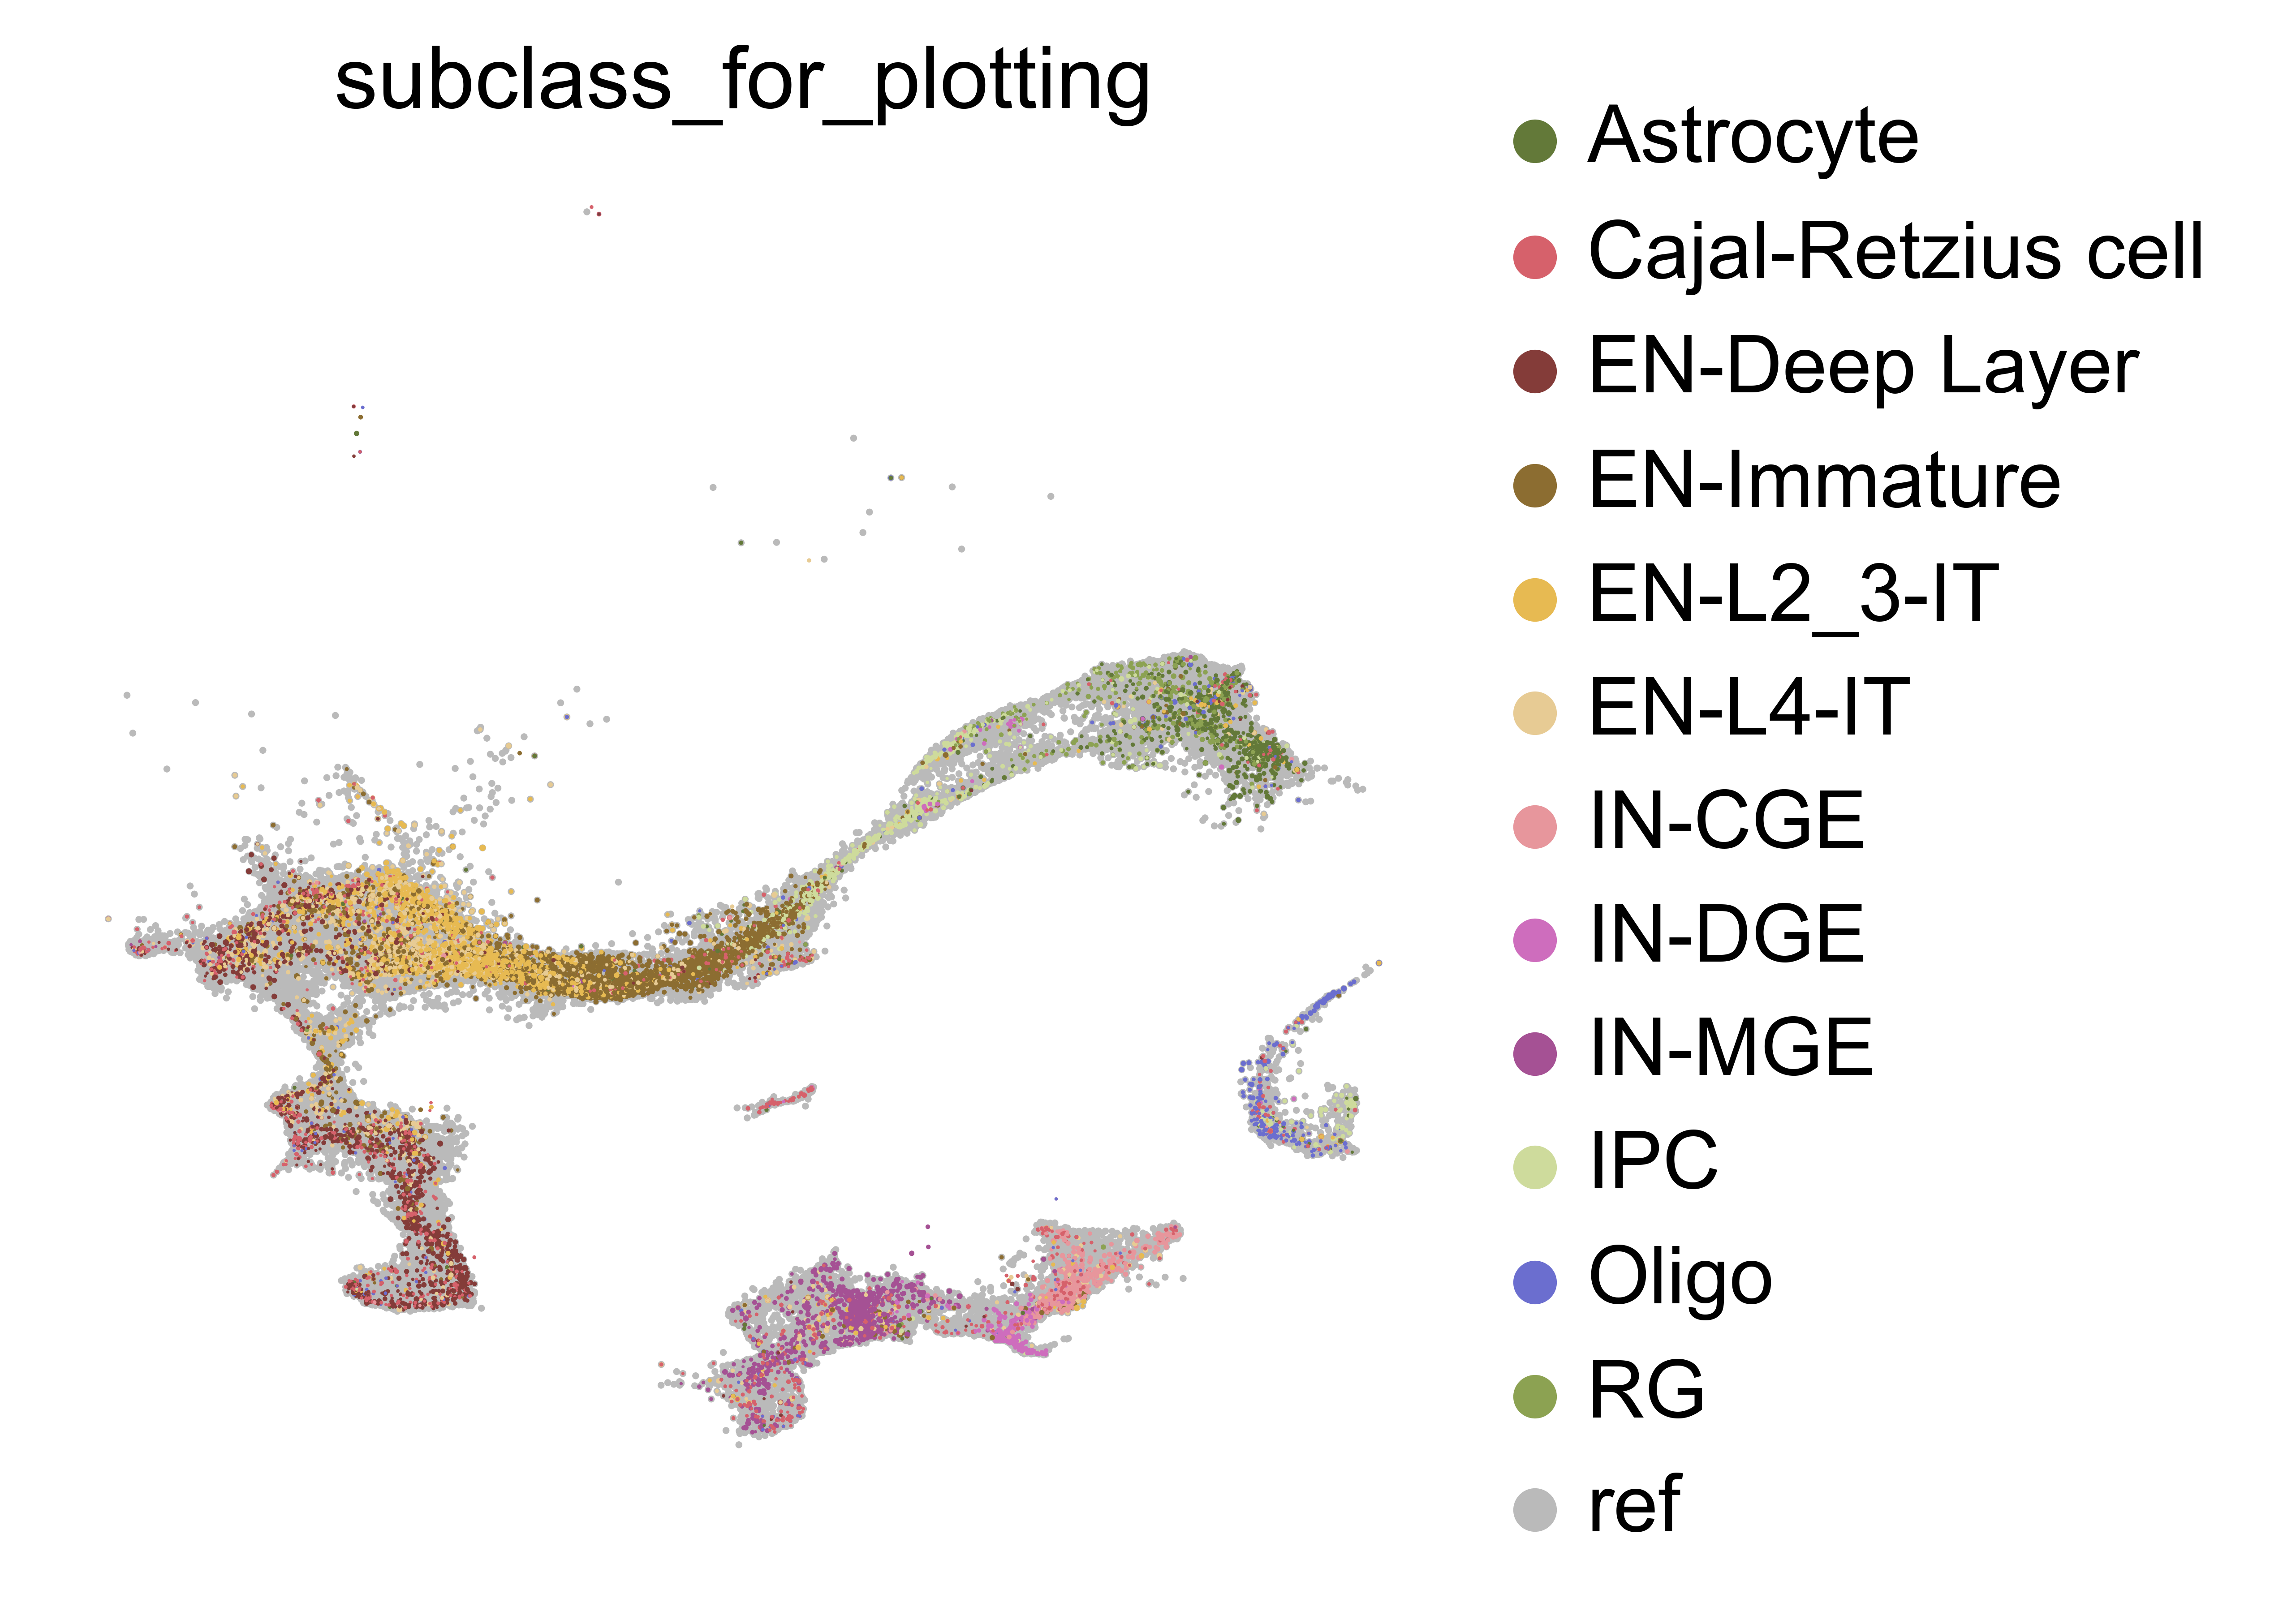

In [48]:
#Subclass types
sizes=np.array(subset_w_ref.obs['high_score']*5)
sizes

cell_type_palette=['#637939','#d6616b','#843c39','#8c6d31','#e7ba52','#e7cb94','#e7969c','#ce6dbd','#a55194','#cedb9c','#6b6ecf','#8ca252','#bababa']

sc.pl.umap(subset_w_ref, 
           color='subclass_for_plotting',
           size=sizes,
           palette=cell_type_palette,
           #legend_fontsize=7,
           #legend_fontoutline=2,
           #legend_loc='on data',
           frameon=False,
           save='_subclass.pdf'
          )

/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/lib/python3.9/site-packages/anndata/_core/anndata.py:1145: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/lib/python3.9/site-packa

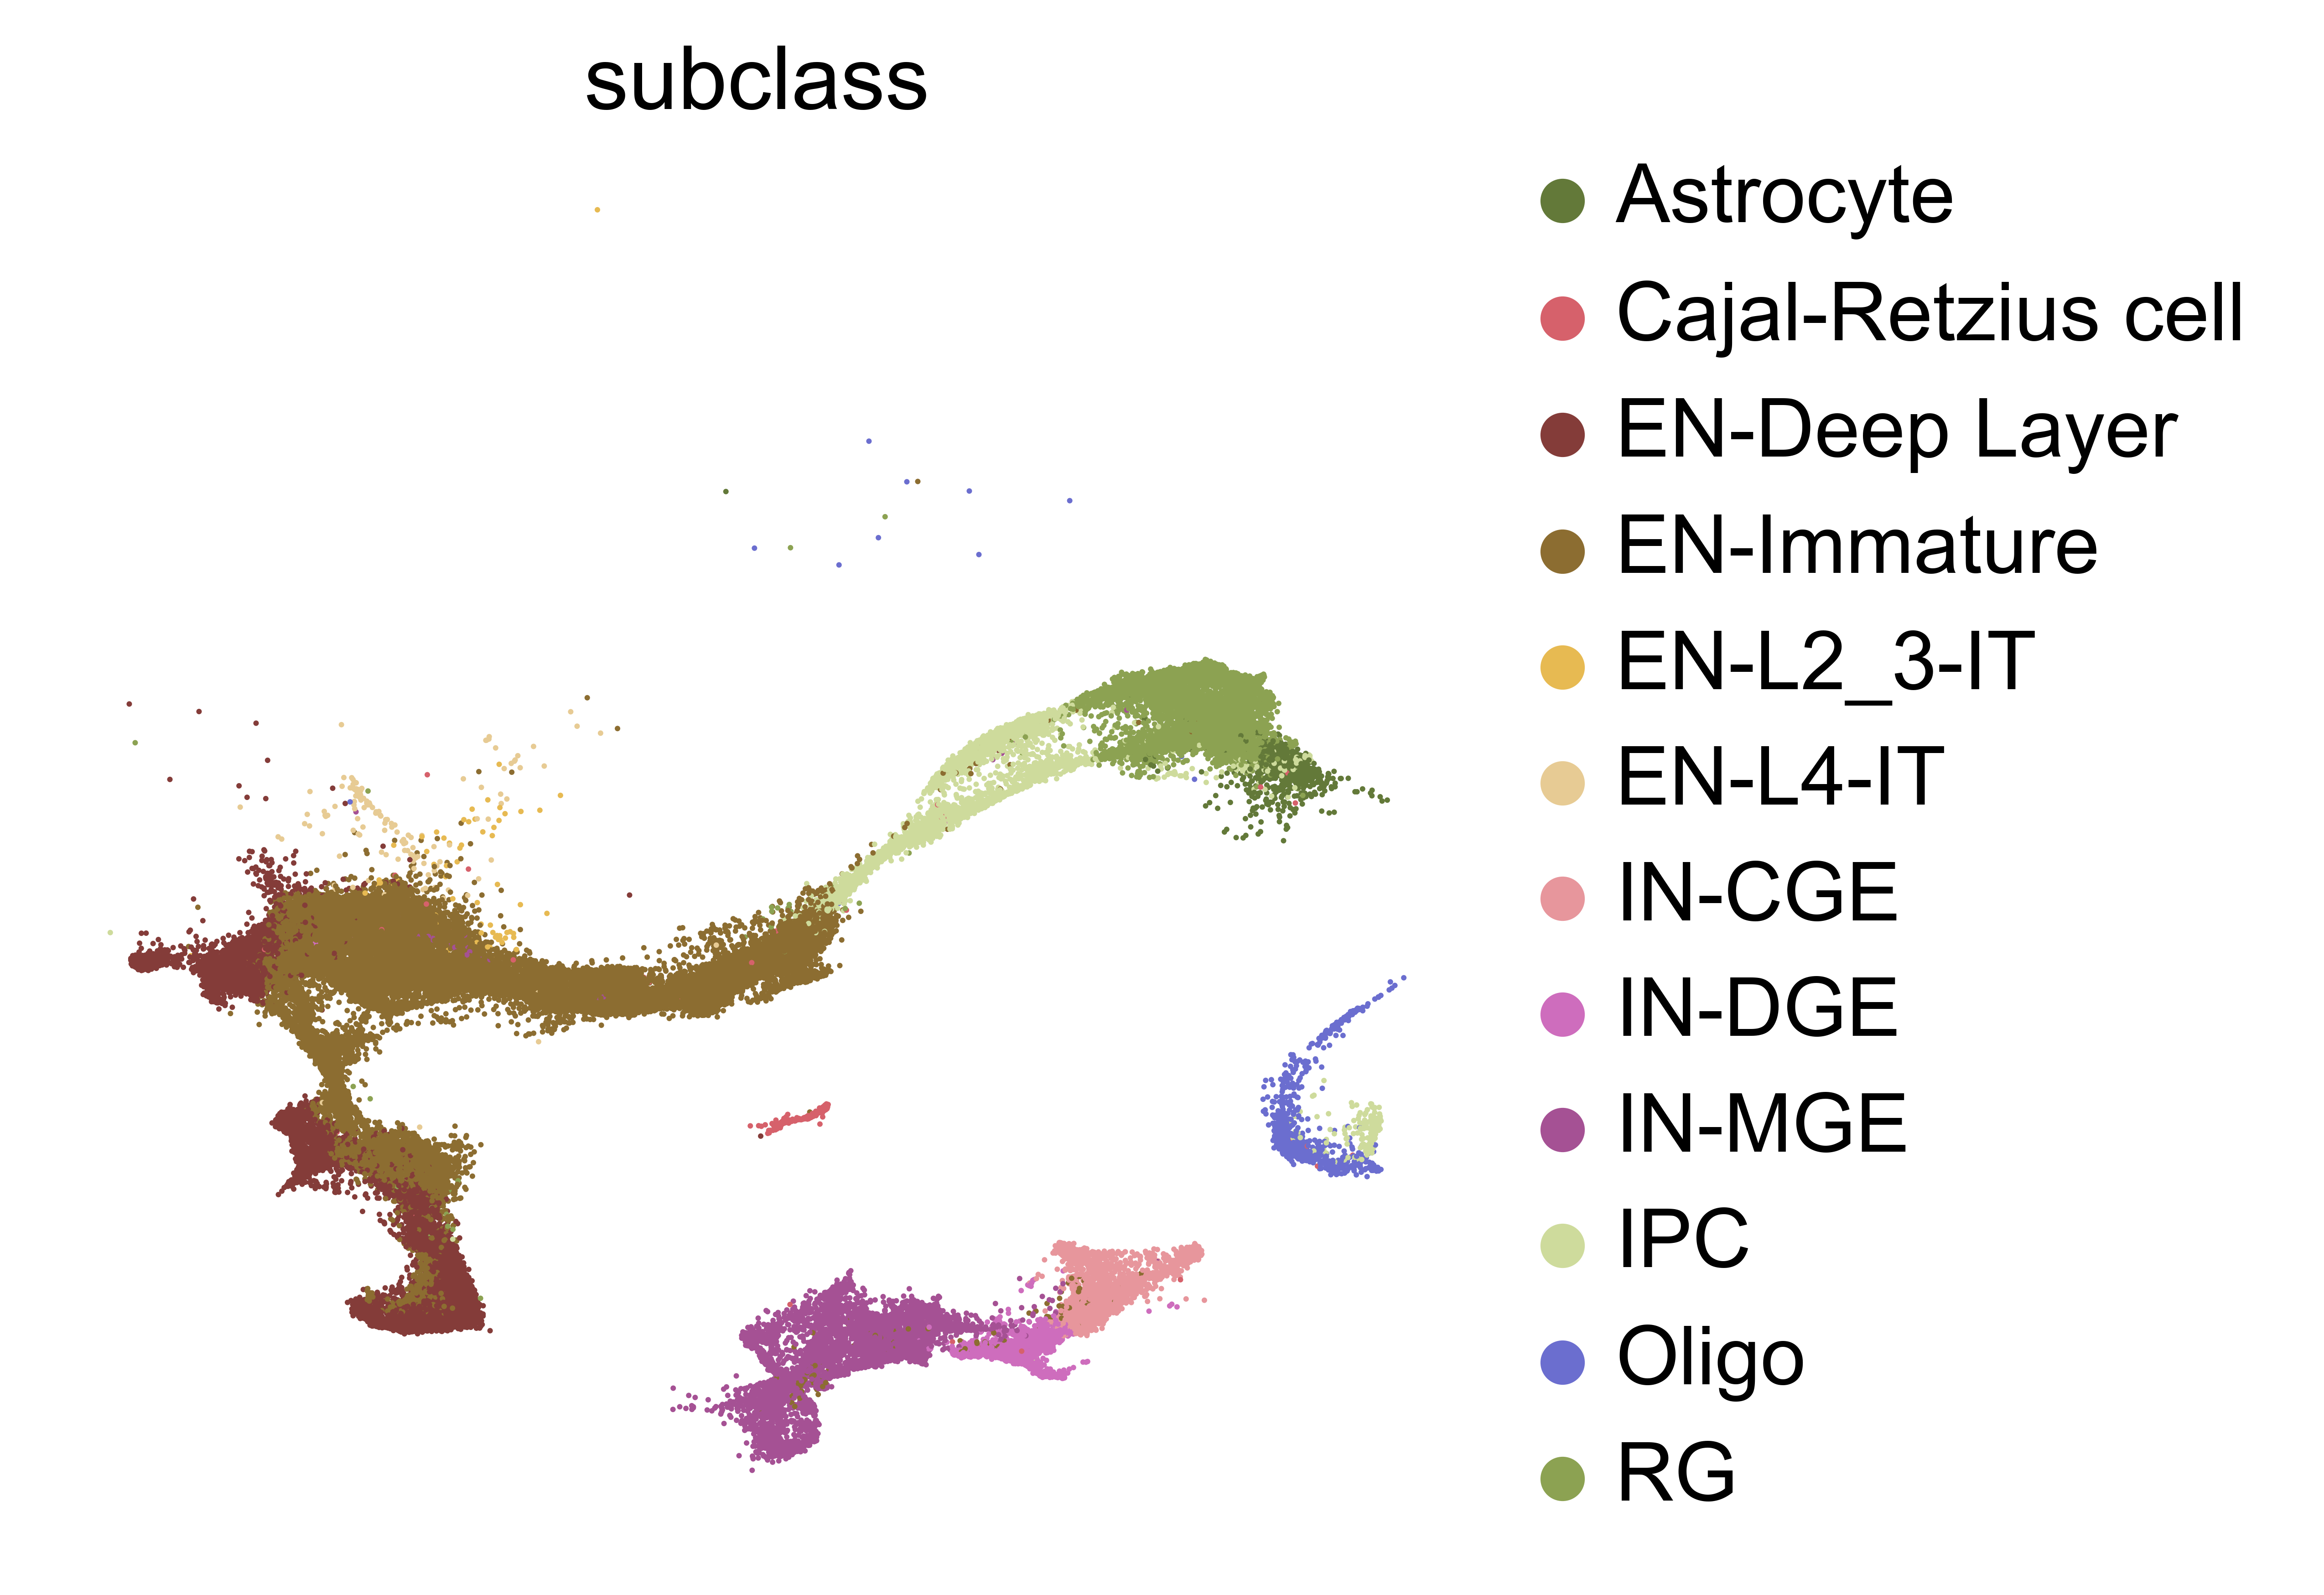

In [244]:
#Reference only
ref_only = subset_w_ref[subset_w_ref.obs.dataset_id == "ref"]

#Subclass types

cell_type_palette=['#637939','#d6616b','#843c39','#8c6d31','#e7ba52','#e7cb94','#e7969c','#ce6dbd','#a55194','#cedb9c','#6b6ecf','#8ca252','#bababa']

sc.pl.umap(ref_only, 
           color='subclass',
           size=3,
           palette=cell_type_palette,
           #legend_fontsize=7,
           #legend_fontoutline=2,
           #legend_loc='on data',
           frameon=False,
           save='_ref_only_subclass.pdf'
          )

### Normalize AnnData object for feature plots

In [47]:
#Remaking AnnData object with just sample data
matrices=[u1_matrix,
          u2_matrix,
          s1_matrix, 
          s2_matrix,
          s3_matrix,
          s4_matrix,
          s5_matrix,
          c1_matrix,
          c2_matrix,
          c3_matrix,
          c4_matrix,
          n1_matrix,
          n2_matrix,
          n3_matrix,
          n4_matrix 
]

pooled_matrix=pd.concat(matrices, axis=1)

#Transpose to match input into scanpy
pooled_matrix=pooled_matrix.T

In [48]:
#Drop any cells that don't appear in metadata
filtered_matrix=pooled_matrix.loc[pooled_matrix.index.isin(subset_w_ref.obs.index)]
filtered_matrix

MIR1302-2HG  FAM138A  OR4F5  ENSG00000238009  \
u1_AAAAAAACCCGAATAA            0        0      0                0   
u1_AAAAAAAGATCGACAC            0        0      0                0   
u1_AAAAAAAGATTTAAGG            0        0      0                0   
u1_AAAAAAAGCCAGCCTG            0        0      0                0   
u1_AAAAAAATCATGAATG            0        0      0                0   
...                          ...      ...    ...              ...   
n4_CCTTACCTCCTCCCTA            0        0      0                0   
n4_CCTTACGGACAAAAGG            0        0      0                0   
n4_CCTTCAGTCACTAAGG            0        0      0                0   
n4_CCTTCCAGACGTCAGG            0        0      0                0   
n4_CCTTCCAGAGTTCCCT            0        0      0                0   

                     ENSG00000239945  ENSG00000239906  ENSG00000241860  \
u1_AAAAAAACCCGAATAA                0                0                0   
u1_AAAAAAAGATCGACAC                0                0                0   
u1_AAAAAAAGATTTAAGG                0                0                0   
u1_AAAAAAAGCCAGCCTG                0                0                0   
u1_AAAAAAATCATGAATG                0                0                0   
...                              ...              ...              ...   
n4_CCTTACCTCCTCCCTA                0                0                0   
n4_CCTTACGGACAAAAGG                0                0                0   
n4_CCTTCAGTCACTAAGG                0                0                0   
n4_CCTTCCAGACGTCAGG                0                0                0   
n4_CCTTCCAGAGTTCCCT                0                0                0   

                     ENSG00000241599  ENSG00000286448  ENSG00000236601  ...  \
u1_AAAAAAACCCGAATAA                0                0                0  ...   
u1_AAAAAAAGATCGACAC                0                0                0  ...   
u1_AAAAAAAGATTTAAGG                0                0                0  ...   
u1_AAAAAAAGCCAGCCTG                0                0                0  ...   
u1_AAAAAAATCATGAATG                0                0                0  ...   
...                              ...              ...              ...  ...   
n4_CCTTACCTCCTCCCTA                0                0                0  ...   
n4_CCTTACGGACAAAAGG                0                0                0  ...   
n4_CCTTCAGTCACTAAGG                0                0                0  ...   
n4_CCTTCCAGACGTCAGG                0                0                0  ...   
n4_CCTTCCAGAGTTCCCT                0                0                0  ...   

                     ENSG00000275249  ENSG00000274792  ENSG00000274175  \
u1_AAAAAAACCCGAATAA                0                0                0   
u1_AAAAAAAGATCGACAC                0                0                0   
u1_AAAAAAAGATTTAAGG                0                0                0   
u1_AAAAAAAGCCAGCCTG                0                0                0   
u1_AAAAAAATCATGAATG                0                0                0   
...                              ...              ...              ...   
n4_CCTTACCTCCTCCCTA                0                0                0   
n4_CCTTACGGACAAAAGG                0                0                0   
n4_CCTTCAGTCACTAAGG                0                0                0   
n4_CCTTCCAGACGTCAGG                0                0                0   
n4_CCTTCCAGAGTTCCCT                0                0                0   

                     ENSG00000275869  ENSG00000273554  ENSG00000277836  \
u1_AAAAAAACCCGAATAA                0                0                0   
u1_AAAAAAAGATCGACAC                0                0                0   
u1_AAAAAAAGATTTAAGG                0                0                0   
u1_AAAAAAAGCCAGCCTG                0                0                0   
u1_AAAAAAATCATGAATG                0                0                0   
...                  

In [49]:
#Make scanpy AnnData object for plot visualization
subset = sc.AnnData(filtered_matrix)
subset

AnnData object with n_obs × n_vars = 44887 × 37468

In [50]:
#Add metadata
subset_metadata=subset_w_ref.obs.loc[subset_w_ref.obs.index.isin(subset.obs.index)]
subset.obs=pd.concat([subset.obs,subset_metadata],axis=1)
subset.obs

high_score dataset_id        type_updated     umap_1  \
u1_AAAAAAACCCGAATAA    0.370670         u1  EN-Non-IT-Immature  -6.663230   
u1_AAAAAAAGATCGACAC    0.352540         u1   Astrocyte-Fibrous   8.150841   
u1_AAAAAAAGATTTAAGG    0.388167         u1   Astrocyte-Fibrous  10.011771   
u1_AAAAAAAGCCAGCCTG    0.338248         u1              RG-vRG   5.308177   
u1_AAAAAAATCATGAATG    0.400080         u1           IN-MGE-PV   1.720893   
...                         ...        ...                 ...        ...   
n4_CCTTACCTCCTCCCTA    0.389516         n4          EN-L2_3-IT  -7.106303   
n4_CCTTACGGACAAAAGG    0.223439         n4  Cajal-Retzius cell   1.045214   
n4_CCTTCAGTCACTAAGG    0.322839         n4  Cajal-Retzius cell  -6.628959   
n4_CCTTCCAGACGTCAGG    0.346355         n4          EN-L2_3-IT  -0.532031   
n4_CCTTCCAGAGTTCCCT    0.271578         n4  Cajal-Retzius cell   6.639900   

                        umap_2 broad_class            subclass  \
u1_AAAAAAACCCGAATAA  -5.493468          EN         EN-Immature   
u1_AAAAAAAGATCGACAC   5.701342        Glia           Astrocyte   
u1_AAAAAAAGATTTAAGG   4.102261        Glia           Astrocyte   
u1_AAAAAAAGCCAGCCTG -11.087727        Glia                  RG   
u1_AAAAAAATCATGAATG  -9.797087          IN              IN-MGE   
...                        ...         ...                 ...   
n4_CCTTACCTCCTCCCTA  -0.497166          EN          EN-L2_3-IT   
n4_CCTTACGGACAAAAGG  -5.074624          EN  Cajal-Retzius cell   
n4_CCTTCAGTCACTAAGG -10.011573          EN  Cajal-Retzius cell   
n4_CCTTCCAGACGTCAGG  -1.796884          EN          EN-L2_3-IT   
n4_CCTTCCAGAGTTCCCT  -9.322276          EN  Cajal-Retzius cell   

                    subclass_for_plotting rabies_infected helper_infected  \
u1_AAAAAAACCCGAATAA           EN-Immature               n               n   
u1_AAAAAAAGATCGACAC             Astrocyte               n               n   
u1_AAAAAAAGATTTAAGG             Astrocyte               n               n   
u1_AAAAAAAGCCAGCCTG                    RG               n               n   
u1_AAAAAAATCATGAATG                IN-MGE               n               n   
...                                   ...             ...             ...   
n4_CCTTACCTCCTCCCTA            EN-L2_3-IT               y               n   
n4_CCTTACGGACAAAAGG    Cajal-Retzius cell               y               n   
n4_CCTTCAGTCACTAAGG    Cajal-Retzius cell               y               n   
n4_CCTTCCAGACGTCAGG            EN-L2_3-IT               y               n   
n4_CCTTCCAGAGTTCCCT    Cajal-Retzius cell               y               n   

                    viral_strain dissociation_modality        age  
u1_AAAAAAACCCGAATAA   uninfected                  cell  gw15-gw21  
u1_AAAAAAAGATCGACAC   uninfected                  cell  gw15-gw21  
u1_AAAAAAAGATTTAAGG   uninfected                  cell  gw15-gw21  
u1_AAAAAAAGCCAGCCTG   uninfected                  cell  gw15-gw21  
u1_AAAAAAATCATGAATG   uninfected                  cell  gw15-gw21  
...                          ...                   ...        ...  
n4_CCTTACCTCCTCCCTA      CVS-N2c                   nuc       gw19  
n4_CCTTACGGACAAAAGG      CVS-N2c                   nuc       gw19  
n4_CCTTCAGTCACTAAGG      CVS-N2c                   nuc       gw19  
n4_CCTTCCAGACGTCAGG      CVS-N2c                   nuc       gw19  
n4_CCTTCCAGAGTTCCCT      CVS-N2c                   nuc       gw19  

[44887 rows x 13 columns]

In [51]:
#Normalizing gene expression for feature plots
#Excluding highly expressed
sc.pp.normalize_total(
    subset,
    target_sum=1e4,
    exclude_highly_expressed=True)
sc.pp.log1p(subset)
subset.layers['log1p']=subset.X.copy()

In [52]:
#Send embeddings to .obsm for plotting
coords=subset.obs[['umap_1', 'umap_2']].to_numpy()
subset.obsm['umap'] = coords
subset.obsm

AxisArrays with keys: umap

### Feature plots

In [31]:
#Set up plotting parameters
plt.rcParams['figure.figsize'] = [0.5,0.5]
plt.rc('font', family='Arial')
sc.set_figure_params(dpi=50, dpi_save=1000)

In [32]:
#Make function for plotting feature plots
def plot_features(data, features):
    for i in features:
        sc.pl.umap(data, 
                   color=i,
                   color_map='magma',
                   #vmin=4,
                   #vmin=lower,
                   #vmax=upper,
                   #vmax=.95,
                   legend_fontsize=7,
                   legend_fontoutline=2,
                   legend_loc='on data',
                   ncols=4,
                   size=5,
                   frameon=False, 
                   save=(f'_{i}.pdf')
                  )

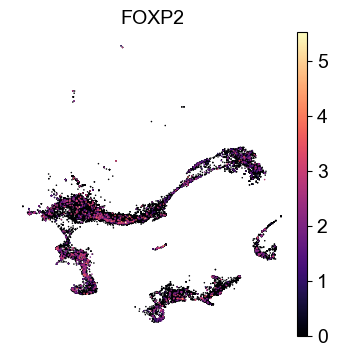

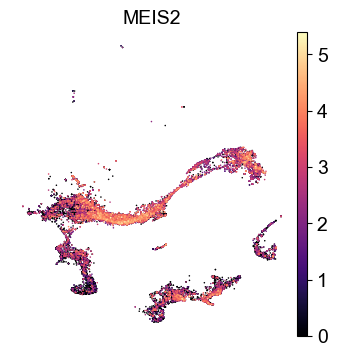

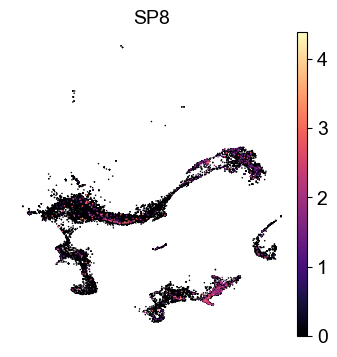

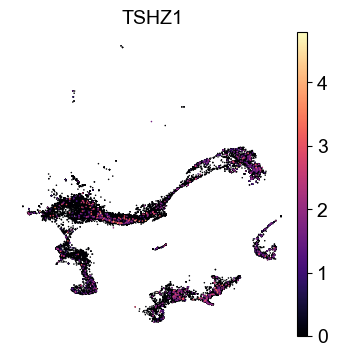

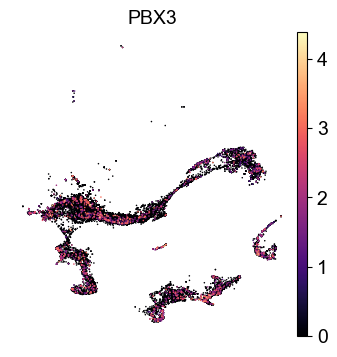

In [33]:
#Plot feature plots
plot_features(subset,['FOXP2',
                     'MEIS2',
                     'SP8',
                     'TSHZ1',
                     'PBX3'])

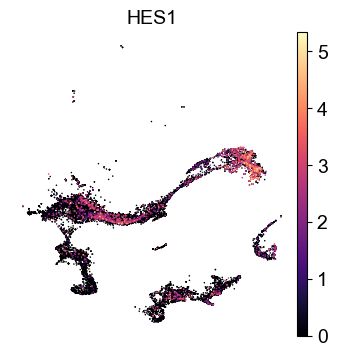

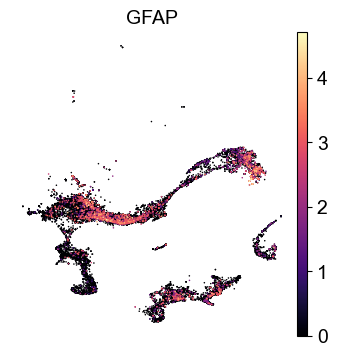

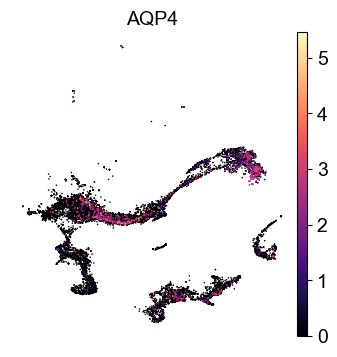

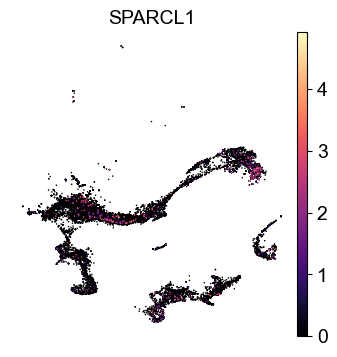

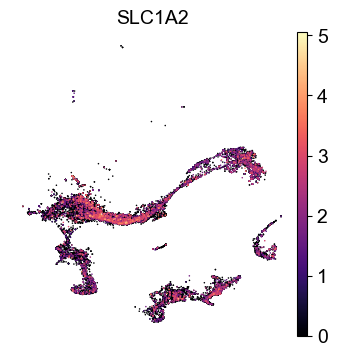

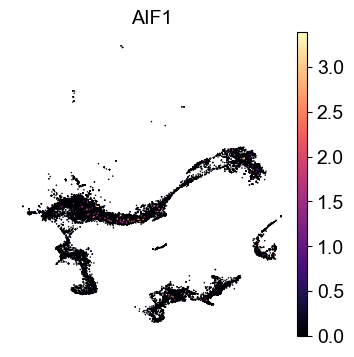

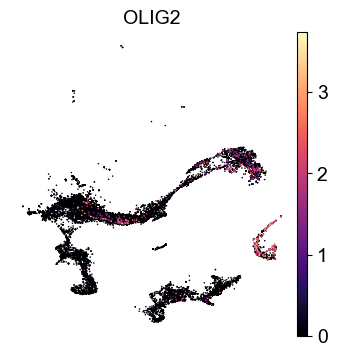

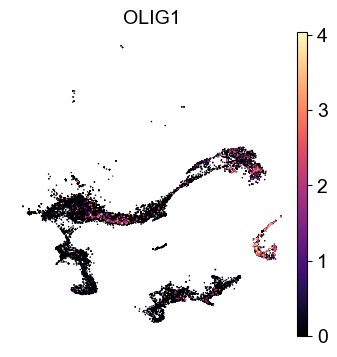

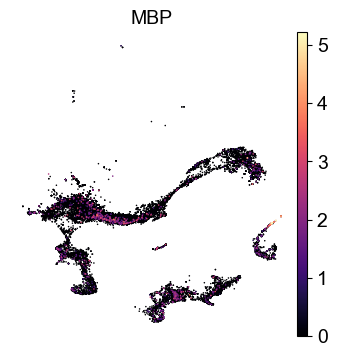

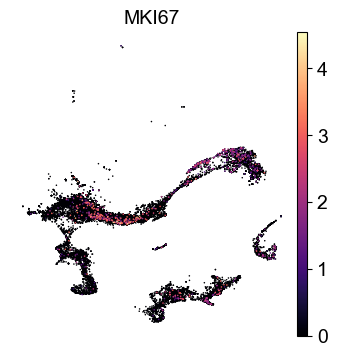

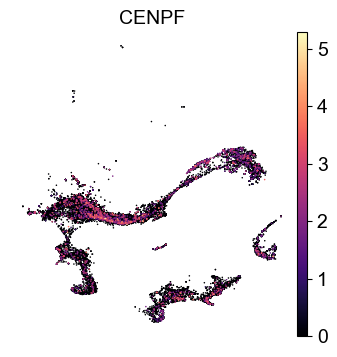

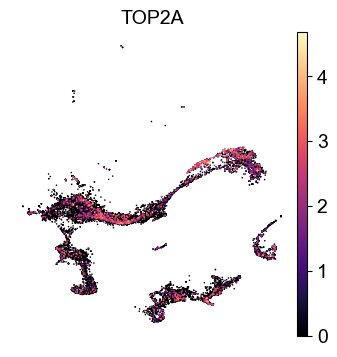

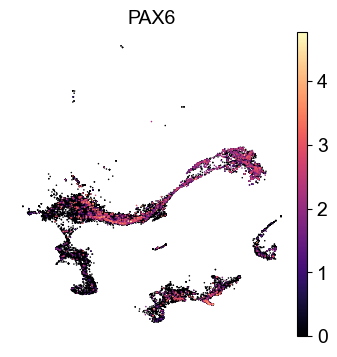

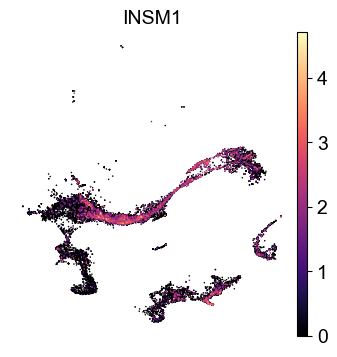

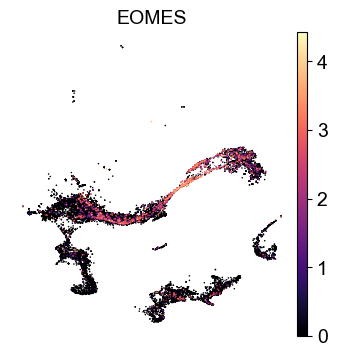

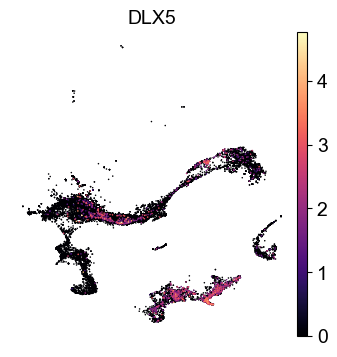

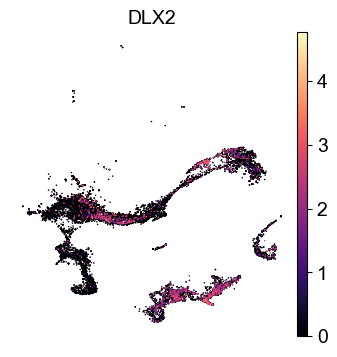

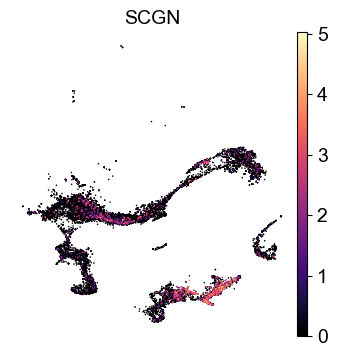

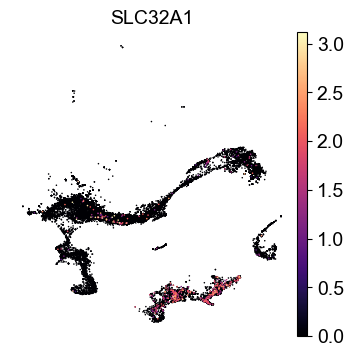

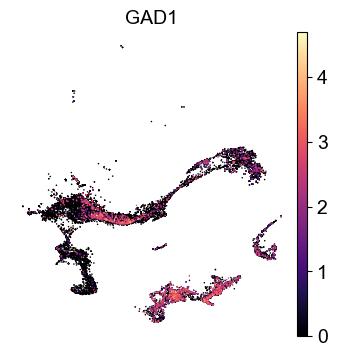

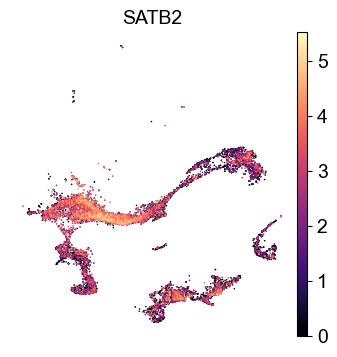

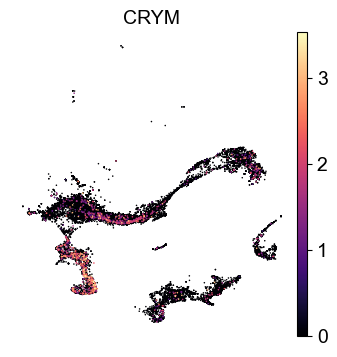

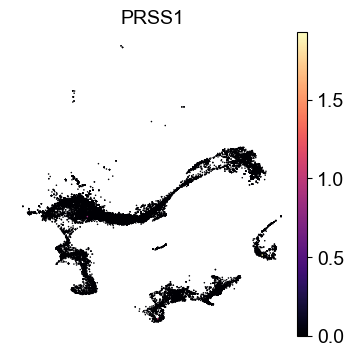

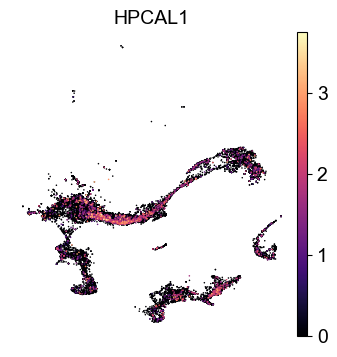

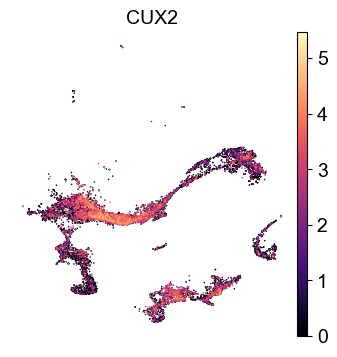

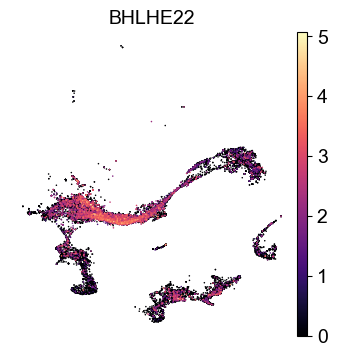

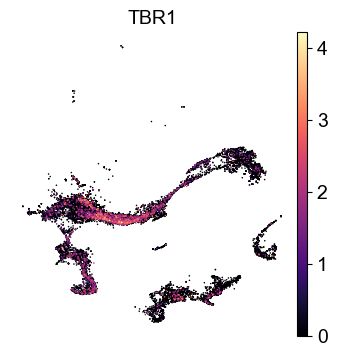

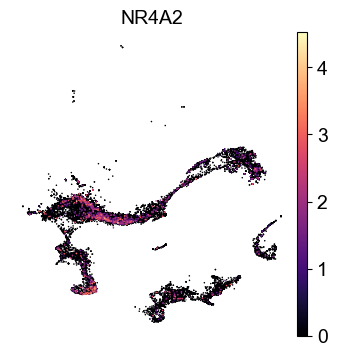

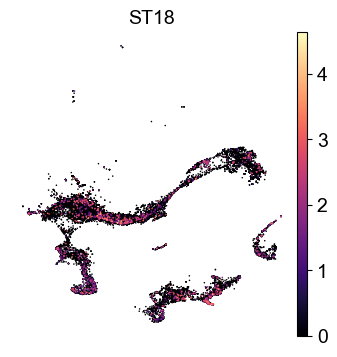

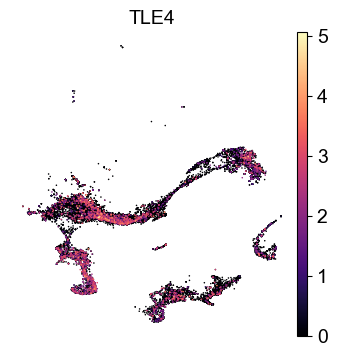

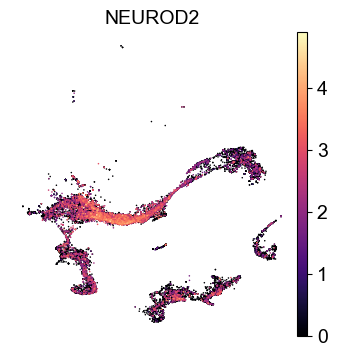

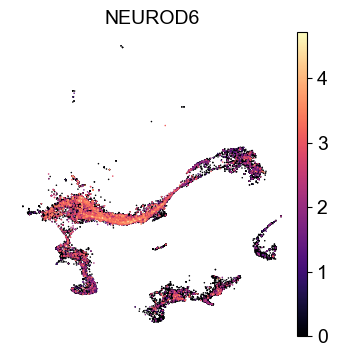

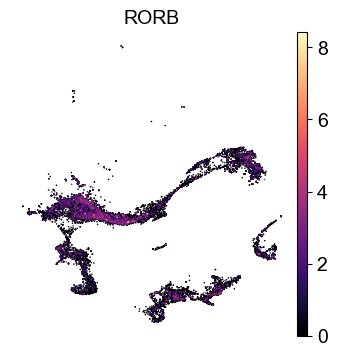

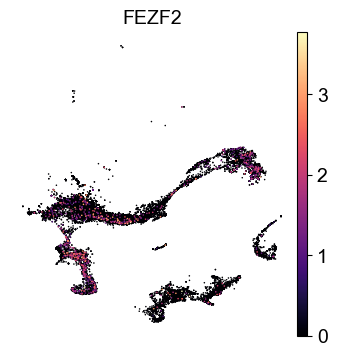

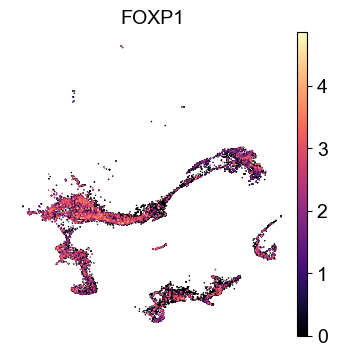

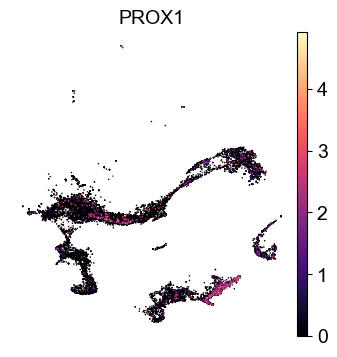

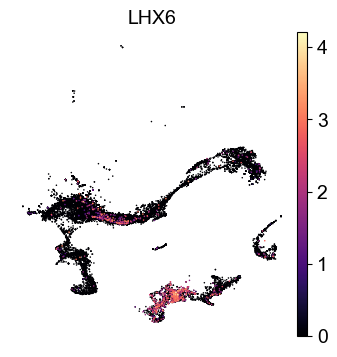

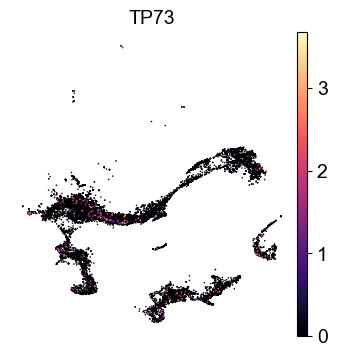

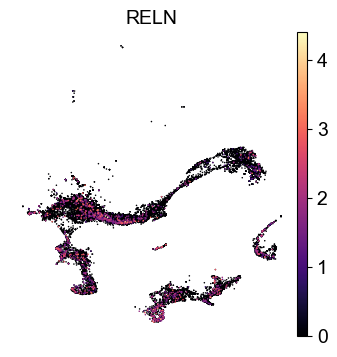

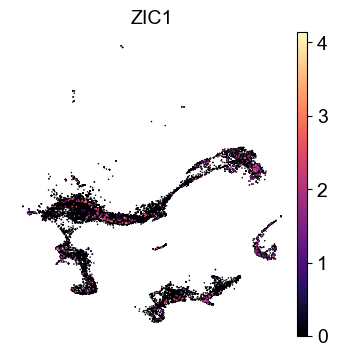

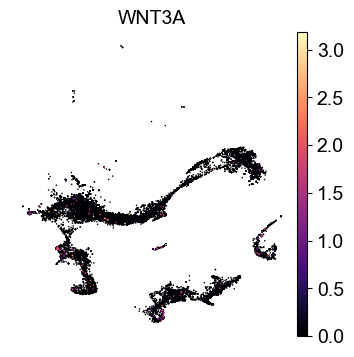

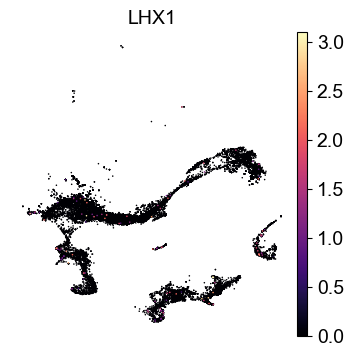

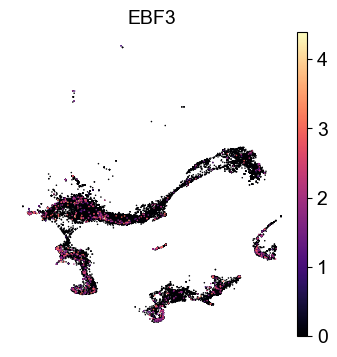

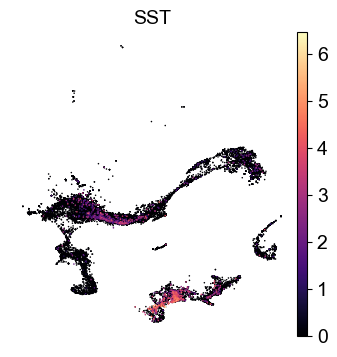

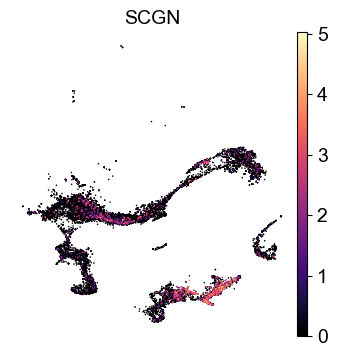

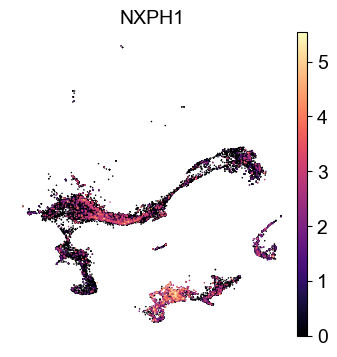

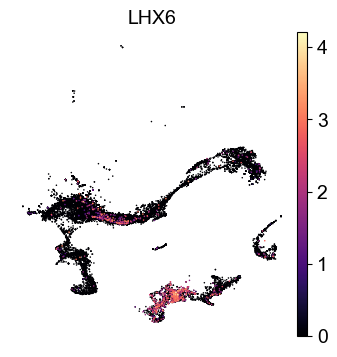

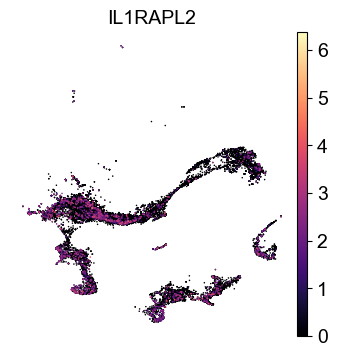

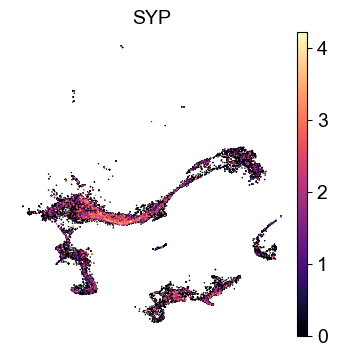

In [57]:
#Plot feature plots
plot_features(subset,['HES1', #RGs
                     'GFAP', #Astrocytes
                     'AQP4',
                     'SPARCL1',
                     'SLC1A2',
                     'AIF1', #Microglia
                     'OLIG2', #OPCs/Oligos
                     'OLIG1',
                     'MBP',
                     'MKI67', #Progenitors
                     'CENPF',
                     'TOP2A',
                     'PAX6',
                     'INSM1',
                     'EOMES',
                     'DLX5', #Inhibitory
                     'DLX2',
                     'SCGN',
                     'SLC32A1',
                     'GAD1',
                     'SATB2', #Excitatory
                    'CRYM',
                     'PRSS1',
                     'HPCAL1',
                     'CUX2',
                     'BHLHE22',
                     'TBR1',
                     'NR4A2',
                     'ST18',
                     'TLE4',
                     'NEUROD2',
                     'NEUROD6',
                     'RORB',
                     'FEZF2',
                     'FOXP1',
                     'PROX1', #CGE
                     'LHX6', #MGE
                    'TP73', #Cajal-Retzius
                    'RELN',
                    'ZIC1',
                    'WNT3A',
                    'LHX1',
                    'EBF3',
                     'SST',
                     'SCGN',
                     'NXPH1',
                     'LHX6',
                     'IL1RAPL2',
                     'SYP'])

### Dot plot

In [34]:
#Set up color map
orig_map=plt.cm.get_cmap('magma')

# reversing the original colormap using reversed() function
reversed_map = orig_map.reversed()

/var/folders/5l/rz29hct17d916rns_lvv75dw0000gn/T/ipykernel_17544/98208608.py:2: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  orig_map=plt.cm.get_cmap('magma')


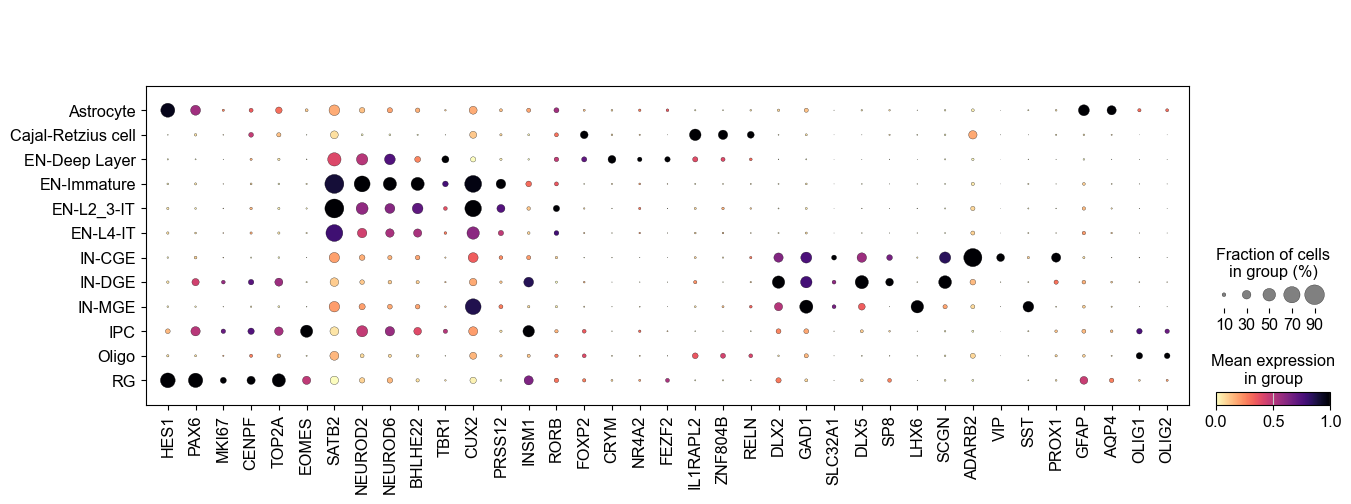

In [37]:
markers=['HES1','PAX6','MKI67','CENPF','TOP2A','EOMES','SATB2','NEUROD2','NEUROD6','BHLHE22','TBR1','CUX2','PRSS12','INSM1','RORB','FOXP2','CRYM','NR4A2','FEZF2','IL1RAPL2','ZNF804B','RELN','DLX2','GAD1','SLC32A1','DLX5', 'SP8','LHX6','SCGN','ADARB2','VIP','SST','PROX1',
        'GFAP','AQP4','OLIG1','OLIG2']
sc.pl.dotplot(subset, markers, groupby='subclass', cmap=reversed_map, dendrogram=False,standard_scale='var',save='.pdf')


### Infection status

Once you run the sorting step, you can't do any feature comparison!

In [53]:
#Add pooled metadata column with all three infection statuses
subset.obs.loc[subset.obs.rabies_infected == 'y', 'infection_status'] = 'RVdG-infected'
subset.obs.loc[subset.obs.helper_infected == 'y', 'infection_status'] = 'Helper-infected'
subset.obs.loc[subset.obs.rabies_infected == 'n', 'infection_status'] = 'Uninfected'

In [54]:
#Sort to put rabies on top and send coords to adata.obsm
subset.obs=subset.obs.sort_values(by='infection_status', ascending=False)
coords=subset.obs[['umap_1', 'umap_2']].to_numpy()
subset.obsm['umap'] = coords

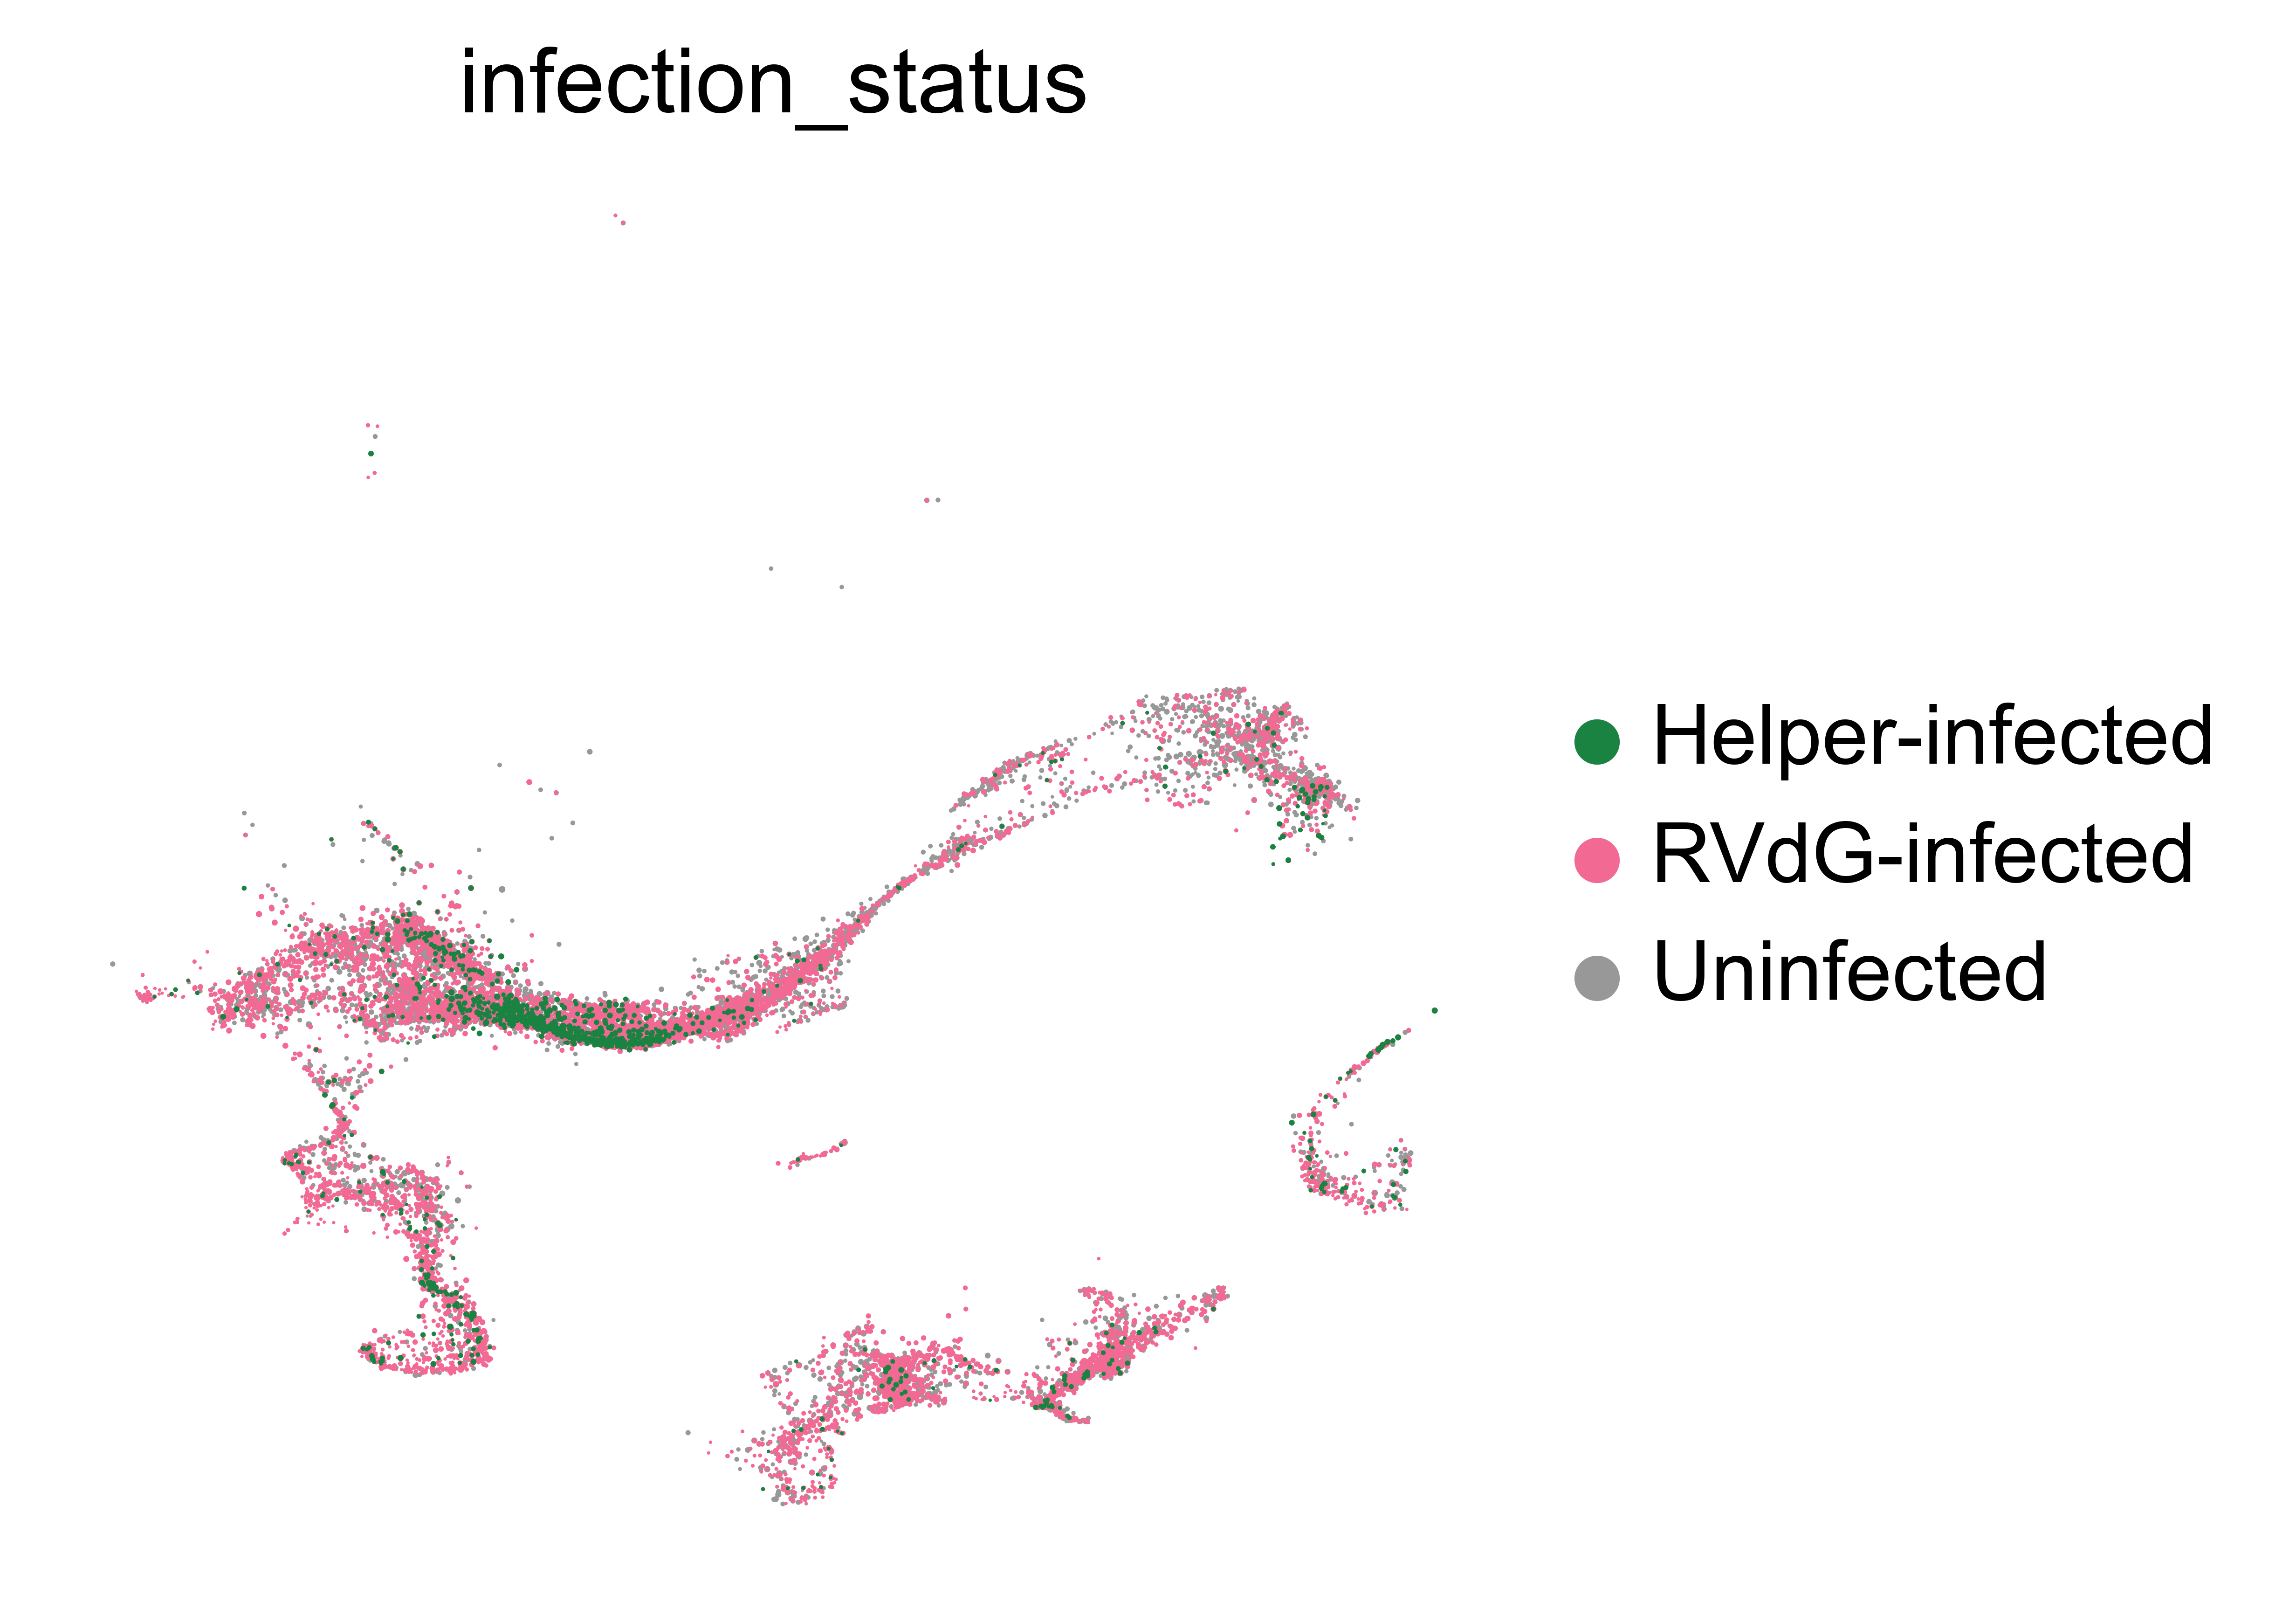

In [55]:
rabies_palette=['#1a8341','#f26994','#989898']


sc.pl.umap(subset, 
           color='infection_status',
           palette=rabies_palette,
           #legend_fontsize=7,
           #legend_fontoutline=2,
           #legend_loc='on data',
           ncols=4,
           size=subset.obs['high_score']*5,
           frameon=False,
           save='_infection_status.pdf')

### Strains

/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/lib/python3.9/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


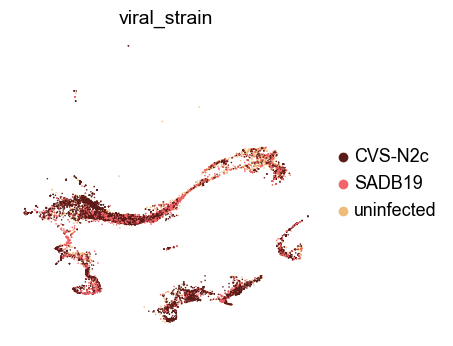

In [63]:
strains = subset[subset.obs.dataset_id.isin(['s1','s2','s3','s4','s5','c1','c2','c3','c4','u1'])]

strain_palette=['#5b1c19','#f16469','#f1bb7a']

sc.pl.umap(strains, 
           color='viral_strain',
           palette=strain_palette,
           #legend_fontsize=7,
           #legend_fontoutline=2,
           #legend_loc='on data',
           ncols=4,
           size=5,
           frameon=False,
           save='_strain.pdf')

### Dissociation methods

/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/lib/python3.9/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


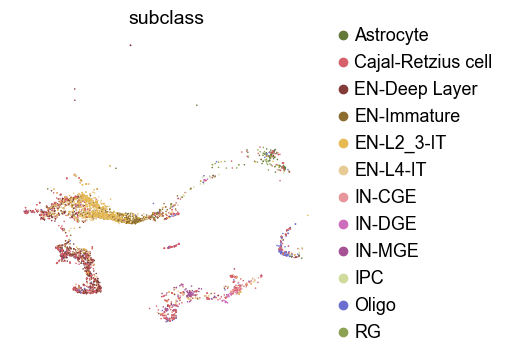

/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/lib/python3.9/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


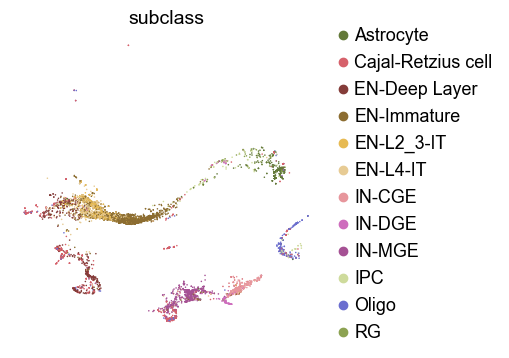

/Users/maddieurbanek/Desktop/Rabies/localanalysis/myenv/lib/python3.9/site-packages/scanpy/plotting/_utils.py:487: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + "_colors"] = colors_list


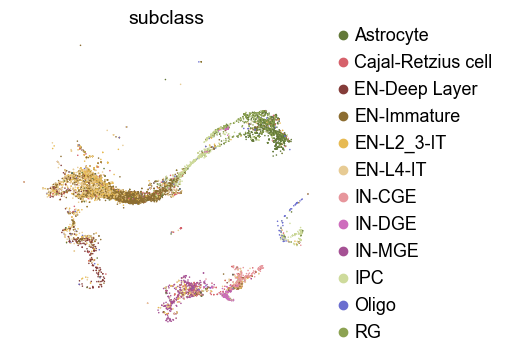

In [64]:
nuc = subset[subset.obs.dataset_id.isin(['n1','n2','n3','n4'])]
cell = subset[subset.obs.dataset_id.isin(['c1','c2','c3','c4'])]
uninfected = subset[subset.obs.dataset_id.isin(['u1','u2'])]

cell_type_palette=['#637939','#d6616b','#843c39','#8c6d31','#e7ba52','#e7cb94','#e7969c','#ce6dbd','#a55194','#cedb9c','#6b6ecf','#8ca252','#bababa']


sc.pl.umap(nuc, 
           color='subclass',
           palette=cell_type_palette,
           #legend_fontsize=7,
           #legend_fontoutline=2,
           #legend_loc='on data',
           ncols=4,
           size=5,
           frameon=False,
           save='_nuc.pdf')

sc.pl.umap(cell, 
           color='subclass',
           palette=cell_type_palette,
           #legend_fontsize=7,
           #legend_fontoutline=2,
           #legend_loc='on data',
           ncols=4,
           size=5,
           frameon=False,
           save='_cell.pdf')


sc.pl.umap(uninfected, 
           color='subclass',
           palette=cell_type_palette,
           #legend_fontsize=7,
           #legend_fontoutline=2,
           #legend_loc='on data',
           ncols=4,
           size=5,
           frameon=False,
           save='_uninfected.pdf')

### Cell type percentage bar plot by age

Extract metadata from subset AnnData object

In [56]:
subset_metadata=subset.obs
subset_metadata['age'].unique()

['gw15-gw21', 'gw19', 'gw15', 'gw21', 'gw22', 'gw20', 'gw16']
Categories (7, object): ['gw15', 'gw15-gw21', 'gw16', 'gw19', 'gw20', 'gw21', 'gw22']

Make function for calculating proportions of cell types for group

In [57]:
def calculate_props(dataset_list, #list of IDs to be pulled from metadata file
                   feature #column name to group samples by
                   ):
    
    final_props=subset_metadata[['subclass']]
    final_props=final_props.drop_duplicates().reset_index()
    
    for i in dataset_list:
        temp = subset_metadata.loc[subset_metadata[feature] == i]
        props=pd.DataFrame(temp['subclass'].value_counts()).reset_index()
        props[f'{i}_proportion']=props['count']/props['count'].sum()
        final_props = final_props.merge(props[['subclass', f'{i}_proportion']], on='subclass', how='left')

    transposed_props=final_props.T
    transposed_props.columns = transposed_props.iloc[1]
    transposed_props = transposed_props[2:]

    #Drop unknown columns
    transposed_props= transposed_props.fillna(0)
    
    return transposed_props


Add dataset ages to filtered_assignments dataframe and calculate proportions

In [58]:
#Run calculate_props() function for paired slice datasets
dataset_list=['gw15', 'gw16','gw19','gw20','gw21','gw22']
final_props=calculate_props(dataset_list, 'age')
final_props

subclass         EN-Immature  EN-L4-IT  EN-Deep Layer  Astrocyte     Oligo  \
gw15_proportion     0.043229  0.057216       0.212651   0.006993  0.089320   
gw16_proportion     0.553360  0.038448       0.063600   0.045275  0.002875   
gw19_proportion     0.183282  0.194847       0.066901   0.047431  0.043185   
gw20_proportion     0.518362  0.030815       0.061629   0.040523  0.039679   
gw21_proportion     0.481937  0.074488       0.002607   0.011732  0.013222   
gw22_proportion     0.346754  0.009039       0.013147   0.152013  0.030403   

subclass         EN-L2_3-IT  Cajal-Retzius cell    IN-MGE    IN-DGE    IN-CGE  \
gw15_proportion    0.062301            0.510490  0.006993  0.000000  0.006675   
gw16_proportion    0.137981            0.000359  0.021559  0.002156  0.010780   
gw19_proportion    0.246230            0.170400  0.016542  0.006880  0.010979   
gw20_proportion    0.159561            0.006754  0.045589  0.030815  0.038835   
gw21_proportion    0.236313            0.047486  0.069274  0.012384  0.032123   
gw22_proportion    0.112572            0.001643  0.066557  0.117502  0.046015   

subclass              IPC        RG  
gw15_proportion  0.001907  0.002225  
gw16_proportion  0.064319  0.059289  
gw19_proportion  0.007027  0.006295  
gw20_proportion  0.013508  0.013930  
gw21_proportion  0.012942  0.005493  
gw22_proportion  0.080526  0.023829

In [68]:
#Sort cell types for input into stacked bar plot
final_props=final_props[['Oligo',
                         'Astrocyte',
                         'RG',
                         'IPC',
                         'EN-Immature',
                         'EN-L2_3-IT',
                         'EN-L4-IT',
                         'EN-Deep Layer',
                         'Cajal-Retzius cell',
                         'IN-CGE',
                         'IN-MGE',
                         'IN-DGE'
                        ]]
final_props['dataset'] = final_props.index
final_props

subclass            Oligo  Astrocyte        RG       IPC  EN-Immature  \
gw15_proportion  0.089320   0.006993  0.002225  0.001907     0.043229   
gw16_proportion  0.002875   0.045275  0.059289  0.064319     0.553360   
gw19_proportion  0.043185   0.047431  0.006295  0.007027     0.183282   
gw20_proportion  0.039679   0.040523  0.013930  0.013508     0.518362   
gw21_proportion  0.013222   0.011732  0.005493  0.012942     0.481937   
gw22_proportion  0.030403   0.152013  0.023829  0.080526     0.346754   

subclass         EN-L2_3-IT  EN-L4-IT  EN-Deep Layer  Cajal-Retzius cell  \
gw15_proportion    0.062301  0.057216       0.212651            0.510490   
gw16_proportion    0.137981  0.038448       0.063600            0.000359   
gw19_proportion    0.246230  0.194847       0.066901            0.170400   
gw20_proportion    0.159561  0.030815       0.061629            0.006754   
gw21_proportion    0.236313  0.074488       0.002607            0.047486   
gw22_proportion    0.112572  0.009039       0.013147            0.001643   

subclass           IN-CGE    IN-MGE    IN-DGE          dataset  
gw15_proportion  0.006675  0.006993  0.000000  gw15_proportion  
gw16_proportion  0.010780  0.021559  0.002156  gw16_proportion  
gw19_proportion  0.010979  0.016542  0.006880  gw19_proportion  
gw20_proportion  0.038835  0.045589  0.030815  gw20_proportion  
gw21_proportion  0.032123  0.069274  0.012384  gw21_proportion  
gw22_proportion  0.046015  0.066557  0.117502  gw22_proportion

Plot stacked bar plot for each age

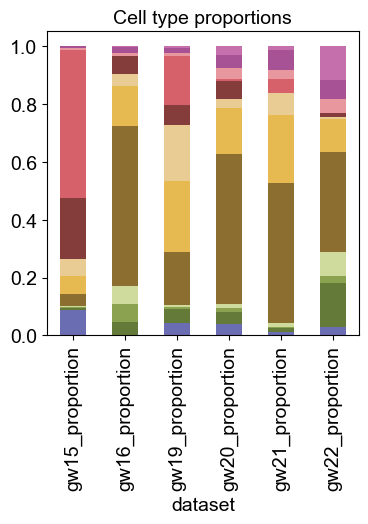

In [69]:
# plot data in stack manner of bar type
cell_type_palette=['#6b6db2','#647a39','#8ba251','#cedb9d','#8d6e31','#e7ba51','#e8cc94','#853d3b','#d6616b','#e7979d','#a75295','#c570ad']
final_props.plot(x='dataset', 
                 kind='bar', 
                 stacked=True,
                 title='Cell type proportions',
                 legend=False,
                 color=cell_type_palette
                )

plt.grid(None)

plt.savefig('../../figs/fig_4/stacked_cell_types.pdf', bbox_inches='tight', format='pdf')

plt.show()

### Cell type proportions by rabies infection status

Calculate proportion of cell types for each rabies_status group

In [59]:
def quantify_by_dataset(dataset, #dataset to split
                   ids #list of IDs to split by
                  ):
    cell_props=pd.DataFrame()

    for i in ids:
        temp = dataset.loc[dataset['dataset_id'] == i]
        temp_h = temp.loc[temp['infection_status'] == 'Helper-infected']
        temp_r = temp.loc[temp['infection_status'] == 'RVdG-infected']
        temp_u = temp.loc[temp['dataset_id'].isin(['u1','u2'])]
        #Calculate proportions for each
        temp_r_props=pd.DataFrame(temp_r['subclass'].value_counts()/len(temp_r)*100)
        temp_r_props['dataset_id']=f'{i}'
        temp_r_props['infection_status']='rabies'
        temp_h_props=pd.DataFrame(temp_h['subclass'].value_counts()/len(temp_h)*100)
        temp_h_props['dataset_id']=f'{i}'
        temp_h_props['infection_status']='helper'
        temp_u_props=pd.DataFrame(temp_u['subclass'].value_counts()/len(temp_u)*100)
        temp_u_props['dataset_id']=f'{i}'
        temp_u_props['infection_status']='uninfected'
        temp=pd.concat([temp_r_props,temp_h_props,temp_u_props])
        cell_props=pd.concat([cell_props,temp])
    cell_props = cell_props.reset_index()

    return cell_props
        

In [60]:
#Run quantify_by_dataset function
cell_props=quantify_by_dataset(subset_metadata,['s1',
                                                     's2',
                                                    's3',
                                                    's4',
                                                    's5',
                                                    'c1',
                                                    'c2',
                                                    'c3',
                                                    'c4',
                                                    'n1',
                                                    'n2',
                                                    'n3',
                                                    'n4',
                                                     'u1',
                                                     'u2'
                                                    ])

cell_props

subclass      count dataset_id infection_status
0      EN-Immature  66.966292         s1           rabies
1           IN-MGE   8.089888         s1           rabies
2              IPC   6.741573         s1           rabies
3        Astrocyte   5.168539         s1           rabies
4           IN-DGE   4.044944         s1           rabies
..             ...        ...        ...              ...
535         IN-DGE   1.613622         u2       uninfected
536         IN-CGE   1.283766         u2       uninfected
537            IPC   0.998484         u2       uninfected
538             RG   0.829099         u2       uninfected
539  EN-Deep Layer   0.410092         u2       uninfected

[540 rows x 4 columns]

Visualize

In [61]:
rabies_palette=['#f26994','#1a8341','#989898']

g = sns.catplot(
    data=cell_props, kind="bar",
    x="subclass", y="count", hue="infection_status",
    errorbar="se", palette=rabies_palette, height=6
)

g.set_axis_labels("Percentage of cells")
g.legend.set_title("")
plt.xticks(rotation=90)
plt.savefig('../../figs/fig_4/temp_cell_props_by_rabies.pdf', bbox_inches='tight', format='pdf')
plt.show()

Stats

In [75]:
clusters=cell_props.subclass.unique()
for i in clusters:
    temp = cell_props.loc[cell_props.subclass == i]
    print(f'{i}, rabies')
    rabies=temp.loc[temp.infection_status == 'rabies']
    rabies=rabies.loc[temp.dataset_id != 'u1']
    rabies=rabies.loc[temp.dataset_id != 'u2']
    rabies['count']=rabies['count'].fillna(0)
    uninfected=temp.loc[temp.infection_status == 'uninfected']
    uninfected=uninfected.dropna()
    print(uninfected['count'])
    print(rabies['count'])
    print(f'{i}, helper')
    helper=temp.loc[temp.infection_status == 'helper']
    helper=helper.loc[helper.dataset_id != 'u1']
    helper=helper.loc[helper.dataset_id != 'u2']
    helper['count']=helper['count'].fillna(0)
    print(stats.dunnett(rabies['count'],helper['count'],control=uninfected['count']))
    print()

EN-Immature, rabies
492    28.554070
530    23.410894
Name: count, dtype: float64
0      66.966292
36     55.781080
72     34.210526
108    46.117274
144    55.503145
180    28.915663
216    54.125452
260     0.191939
292     4.194079
326    19.103774
362     7.878788
400     6.638787
436     7.333333
Name: count, dtype: float64
EN-Immature, helper
Dunnett's test (95.0% Confidence Interval)
Comparison               Statistic  p-value  Lower CI  Upper CI
 (Sample 0 - Control)      0.203     0.950   -38.011    45.579
 (Sample 1 - Control)      0.156     0.970   -38.883    44.707


IN-MGE, rabies
500    2.809842
534    2.995453
Name: count, dtype: float64
1      8.089888
43     2.174701
75     9.038902
113    4.992076
146    6.446541
186    2.265060
219    7.792521
255    0.863724
294    1.480263
328    1.084906
365    2.558923
404    0.627287
438    2.666667
Name: count, dtype: float64
IN-MGE, helper
Dunnett's test (95.0% Confidence Interval)
Comparison               Statistic  p-value  

### Export subset.obs for metadata fields

In [69]:
subset.obs.to_csv('./filtered_metadata.csv')